```
import Pyro4.util
try:
    [run your usual rfsoc experiment here]
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))
```

In [29]:
# %matplotlib widget
%matplotlib inline

In [30]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load experiments

In [31]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

In [32]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [33]:
expt_path=os.getcwd()+'\data'
# expt_path=os.getcwd()+'\data\data_221215'
# expt_path = 'C:\_Data\LLqub'
print('Data will be stored in', expt_path)

Data will be stored in c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data


In [34]:
config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_zcu216_LLStdCandle.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\config_zcu216.yml


# Qubit/resonator to probe

In [35]:
qubit_i = 0

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [36]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [37]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
#im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

In [25]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
print(yaml_cfg['aliases']['soc'])
print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v4 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	1:	axis_signal_gen_v4 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	2:	axis_signal_gen_v4 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	3:	axis_signal_gen_v4 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	4:	axis_signal_gen_v4 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v4 - tProc output 6, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_signal_gen_v4 - tProc out

# RFSoC Calibration

In [26]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    gain=30000, # blast the power just for the RFSoC calibration
    # gain=5000, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=1000, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
print(tof.cfg)

import Pyro4.util
try: 
    tof.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [120.68761341486444, 187.33213316885298, 85.53572444033654, 179.34115523113738, 110.78317042127422, 225.12683789068893], 'f_ge': [3306.331430281384, 3559.5989142350372, 3534.728059761181, 3542.27326403314, 3270.5822861523375, 3791.61038088935], 'f_ef': [4000, 4000, 4000, 4000, 4000, 4000], 'f_EgGf': [2000, 2000, 2000, 2000, 2000, 2000], 'pulses': {'pi_ge': {'gain': [1017, 1021, 989, 969, 975, 989], 'sigma': [0.08795696668925942, 0.12184260004276688, 0.11043317188279761, 0.14281583379905646, 0.08979016287487021, 0.1977267386232169], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000, 10000, 1000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'gain': [6000, 6000, 6000, 5000, 3000, 3000], 'phase': [0, 0, 0, 0, 0, 0], 'threshold': [0, 0, 0, 0, 0, 0], 'readout_length': [5, 5, 5, 5, 

  0%|          | 0/1000 [00:00<?, ?it/s]

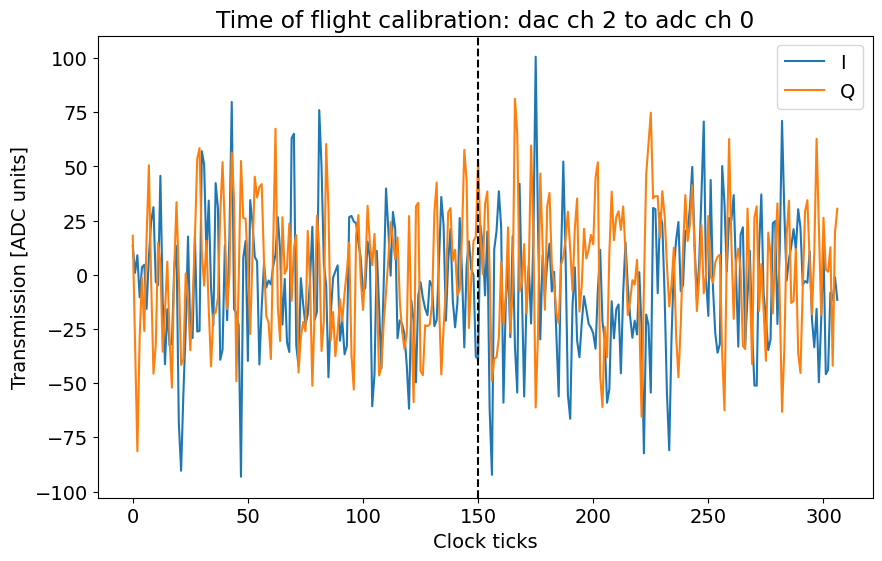

In [27]:
tof.display(adc_trig_offset=150)

In [28]:
tof.save_data()

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00002_adc_trig_offset_calibration_qubit0.h5


# Resonator spectroscopy

## Single tone (resonator) spectroscopy

Measures the resonant frequency of the readout resonator when the qubit is in its ground state: sweep readout pulse frequency and look for the frequency with the maximum measured amplitude.

The resonator frequency should be stored in the parameter <code>cfg.device.readouti.frequency</code>.

Note that harmonics of the clock frequency (6144 MHz) will show up as "infinitely"  narrow peaks!


In [945]:
qubit_i = 2

In [29]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
print(rspec.cfg)
span = 2 # MHz
npts = 500 
# arduino.set_voltage(channel=4, voltage=0.0104)
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.75*span, # resonator frequency to be mixed up [MHz]
    # start=-807-span/2, # resonator frequency to be mixed up [MHz]
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.75*span,
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.25*span,
    # start=0,
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number experiments stepping from start
    reps= 500, # Number averages per point 500
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)

# rspec.cfg.device.readout.gain[qubit_i] = 0.5
# rspec.cfg.device.readout.frequency[qubit_i] = 822.2138666666668

rspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]
# rspec.cfg.device.readout.readout_length = 5

rspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [120.68761341486444, 187.33213316885298, 168.99158742583094, 179.34115523113738, 98.33856218592895, 176.6749889858168], 'f_ge': [3306.331430281384, 3559.5989142350372, 3534.4165657363023, 3542.27326403314, 3270.5822861523375, 3791.61038088935], 'f_ef': [4000, 4000, 4000, 4000, 4000, 4000], 'f_EgGf': [2000, 2000, 2000, 2000, 2000, 2000], 'pulses': {'pi_ge': {'gain': [1017, 1021, 986, 972, 975, 989], 'sigma': [0.08795696668925942, 0.12184260004276688, 0.10965835304102353, 0.1420366397101421, 0.08979016287487021, 0.1977267386232169], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000, 10000, 1000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'gain': [6000, 6000, 6000, 5000, 3000, 3000], 'phase': [0, 0, 0, 0, 0, 0], 'threshold': [0, 0, 0, 0, 0, 0], 'readout_length': [5, 5, 5, 5, 5

  0%|          | 0/500 [00:00<?, ?it/s]

[7096.2445, 5000, 1000, 0, 2.9641891218831184, 2.35676442295868, 0.11557797566891921]
[ 7.09599921e+03  5.00072294e+03  1.00074776e+03  2.27160051e-02
  1.40692436e+01  1.75989526e+00 -1.34744840e-01]

Freq with minimum transmission: 7096.2465
Freq with maximum transmission: 7097.0665
From fit:
	f0: 7095.999205169459
	Qi: 5000.722944402153
	Qe: 1000.7477639922367
	Q0: 833.8726535739443
	kappa [MHz]: 8.50969170742834
	phi [radians]: 0.02271600508260235


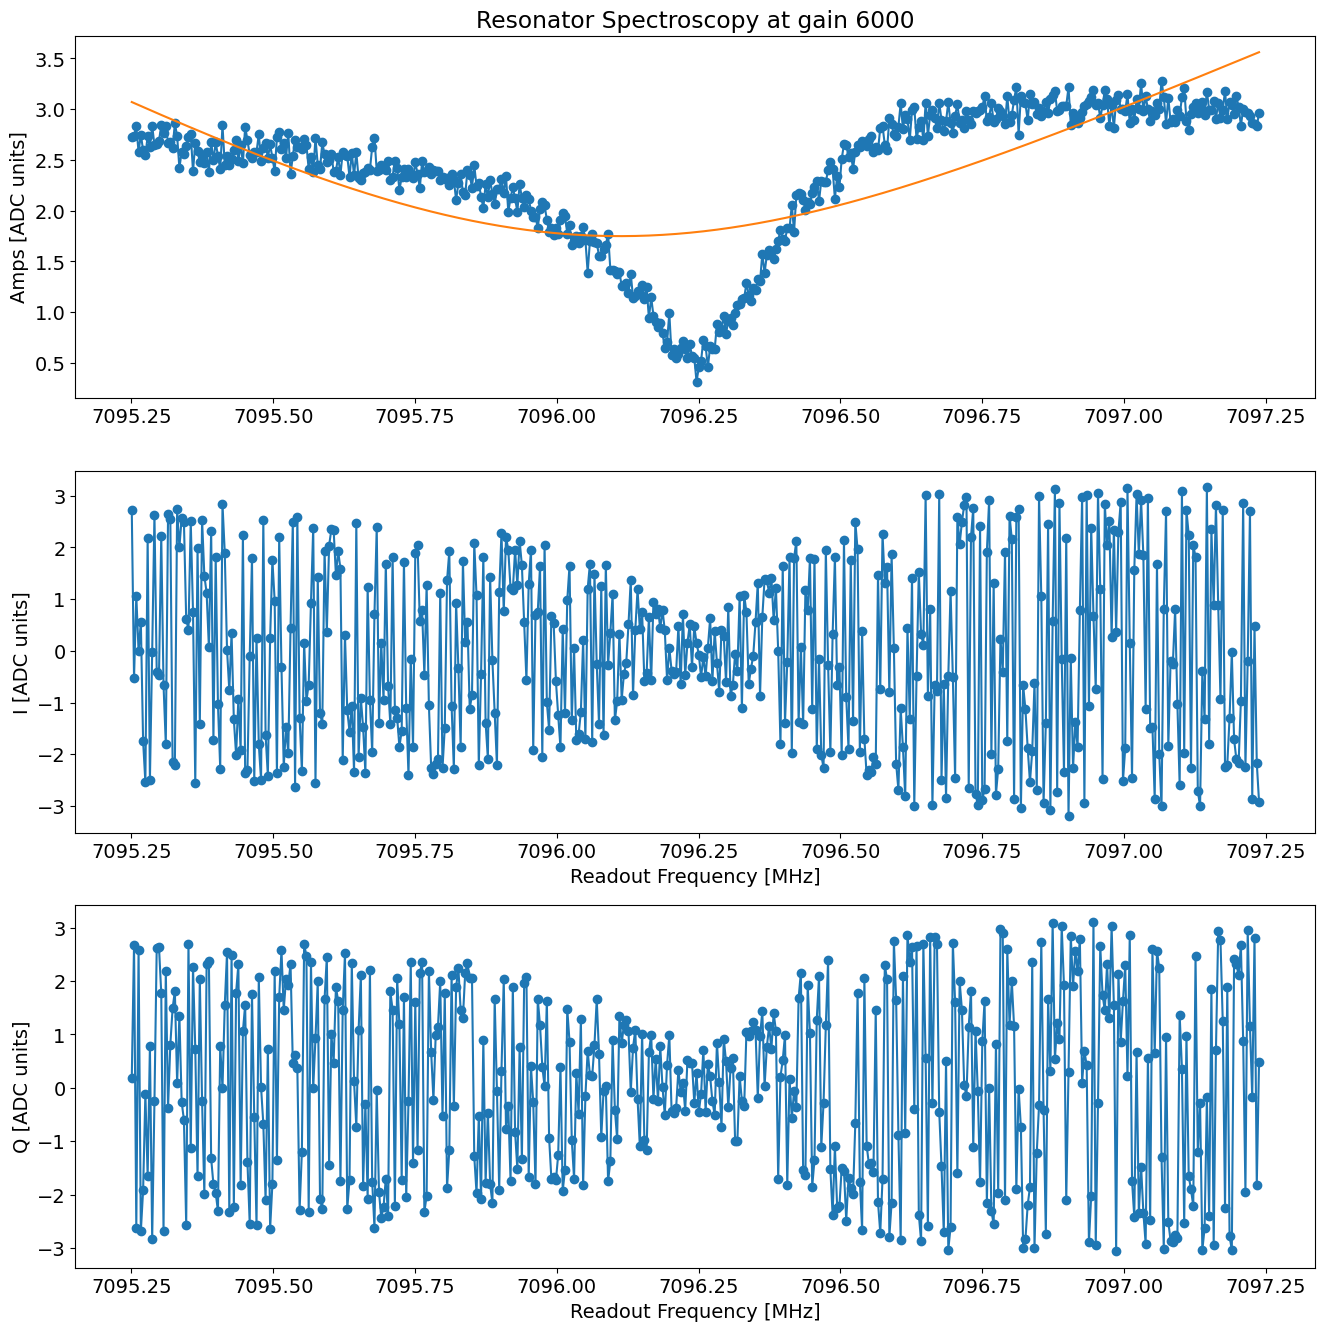

In [30]:
# # TESTING
# rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# # temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit1.h5')
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit0.h5')
# i_gain = np.argmin(np.abs(temp_data['gainpts']-30))
# temp_data['amps'] = temp_data['amps'][i_gain][80:]
# temp_data['xpts'] = temp_data['xpts'][80:]
# data = rspec.analyze(data=temp_data, fit=True)
# rspec.display(data=data, fit=True)

rspec.analyze(fit=True, findpeaks=False)
rspec.display(fit=True, findpeaks=False)

In [916]:
rspec.save_data()

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00001_resonator_spectroscopy_qubit5.h5


## Power sweep resonator spectroscopy

Repeat resonator spectroscopy at a range of powers to check that resonator frequency shifts at low powers. (Check qubit is alive.)

Use this experiment to determine the appropriate resonator gain, which should be stored in <code>cfg.device.readout.gain</code>


In [ ]:
qubit_i = 0 

In [667]:
rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"power_sweep_resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 5.0
npts_f = 200

span_gain = 10000
npts_gain = 16

rpowspec.cfg.expt = dict(
    # start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.75, # sweep frequency [MHz]
    start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.5, # sweep frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=rpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    #start_gain=0.001,
    start_gain=5000,
    step_gain=int(span_gain/npts_gain), # Gain step size
    # step_gain=0, # Gain step size
    expts_gain=npts_gain+1, # Number experiments stepping gain from start
    reps= 500, # Number averages per point
    pulse_e=False, # add ge pi pulse before measurement
    pulse_f=False, # add ef pi pulse before measurement
    qubit=qubit_i,
)
rpowspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]
rpowspec.cfg.device.readout.readout_length = 5

print('1', rpowspec.cfg)
rpowspec.go(analyze=False, display=False, progress=True, save=False)

1 {'device': {'qubit': {'T1': [114.60819807329304, 145.32072588810556, 168.99158742583094, 179.34115523113738, 98.33856218592895, 176.6749889858168], 'f_ge': [3306.331430281384, 3559.5989142350372, 3339.61876102317, 3338.9856784510957, 3270.5822861523375, 3791.61038088935], 'f_ef': [4000, 4000, 4000, 4000, 4000, 4000], 'f_EgGf': [2000, 2000, 2000, 2000, 2000, 2000], 'pulses': {'pi_ge': {'gain': [1017, 1021, 986, 972, 20439, 20097], 'sigma': [0.08795696668925942, 0.12184260004276688, 0.10965835304102353, 0.1420366397101421, 0.08979016287487021, 0.1977267386232169], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000, 10000, 1000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'gain': [6000, 8000, 6000, 5000, 3000, 3000], 'phase': [0, 0, 0, 0, 0, 0], 'threshold': [0, 0, 0, 0, 0, 0], 'readout_length': 5, 'rela

  0%|          | 0/17 [00:00<?, ?it/s]

KeyboardInterrupt: 

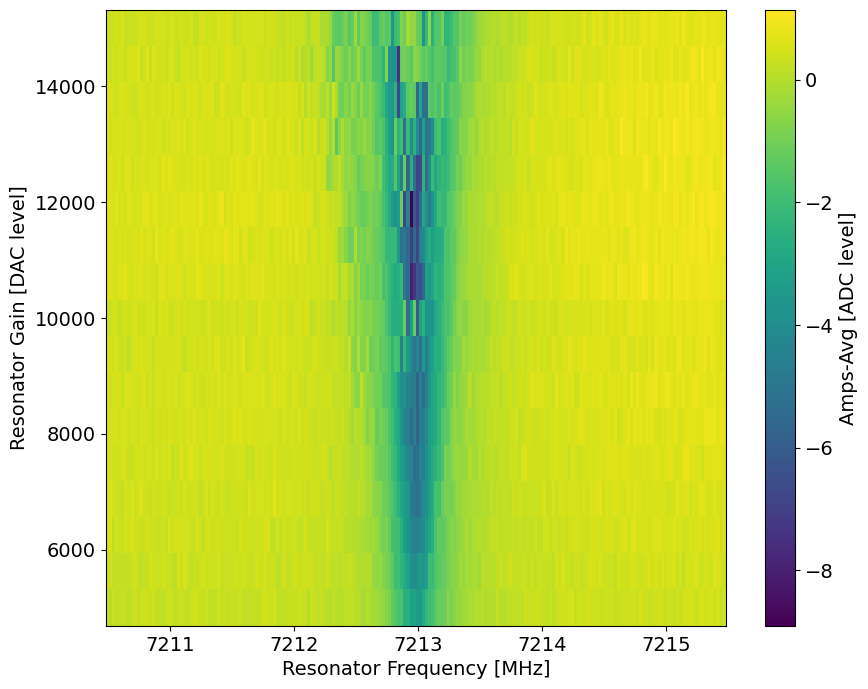

15000


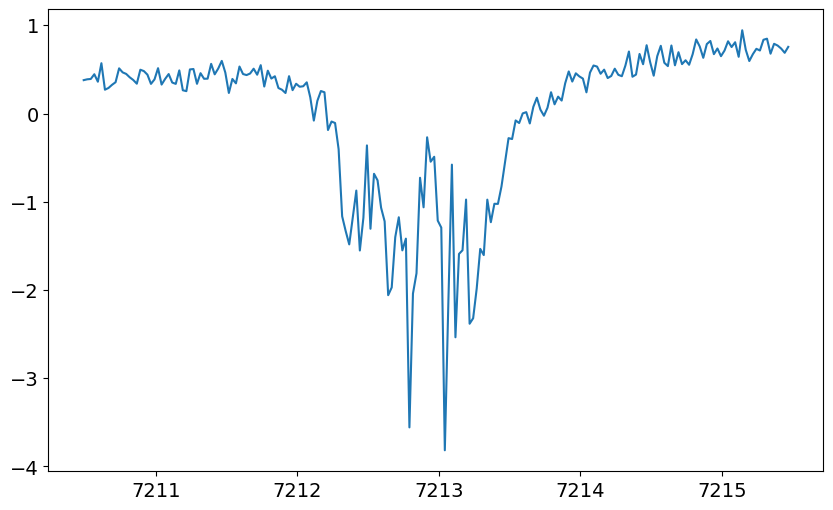

In [427]:
# # TESTING
# rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit1.h5')
# rpowspec.display(data=temp_data, fit=False)

rpowspec.analyze(fit=False, lowgain=None, highgain=None)
rpowspec.display(fit=False)

In [19]:
rpowspec.save_data()

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00000_power_sweep_resonator_spectroscopy_qubit2.h5


# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

Measures the qubit frequency f_ge by driving at resonator frequency and sweeping qubit frequency.

Qubit frequency should be stored in <code>cfg.qubiti.f_ge</code>.

In [40]:
qubit_i = 2

In [41]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 5
npts = 500

# span = 50
# npts = 150

qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    #start=qspec.cfg.device.qubit.f_ge[qubit_i]-50,
    #start=qspec.cfg.device.qubit.f_ge[qubit_i] + 200, # resonator frequency to be mixed up [MHz]
    # start=4780,
    step=span/npts, # min step ~1 MHz
    expts=npts, # Number of experiments stepping from start
    reps=50, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=50, # Qubit probe constant pulse length [us]
    #gain = qspec.cfg.device.qubit.pulses.pi_ge.gain[qubit_i], # Qubit pulse gain
    gain=100, # Qubit pulse gain
    # length=0.1, # Qubit probe constant pulse length [us]
    # gain=10, # Qubit pulse gain
    pulse_type='const',
    #pulse_type='gauss',
    qubit=qubit_i,
)
qspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
# qspec.cfg.device.readout.frequency[qubit_i] = -813.508 # Wait time between experiments [us]
# qspec.cfg.device.readout.gain[qubit_i] = 0.015

#print(qspec.cfg)

qspec.go(analyze=False, display=False, progress=True, save=False)


  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3534.728059761181, HWHM 0.613458338684621
Found peak in I at [MHz] 3533.236932247289, HWHM 0.31710755217953895
Found peak in Q at [MHz] 3534.7278449449514, HWHM 0.6165671942032454


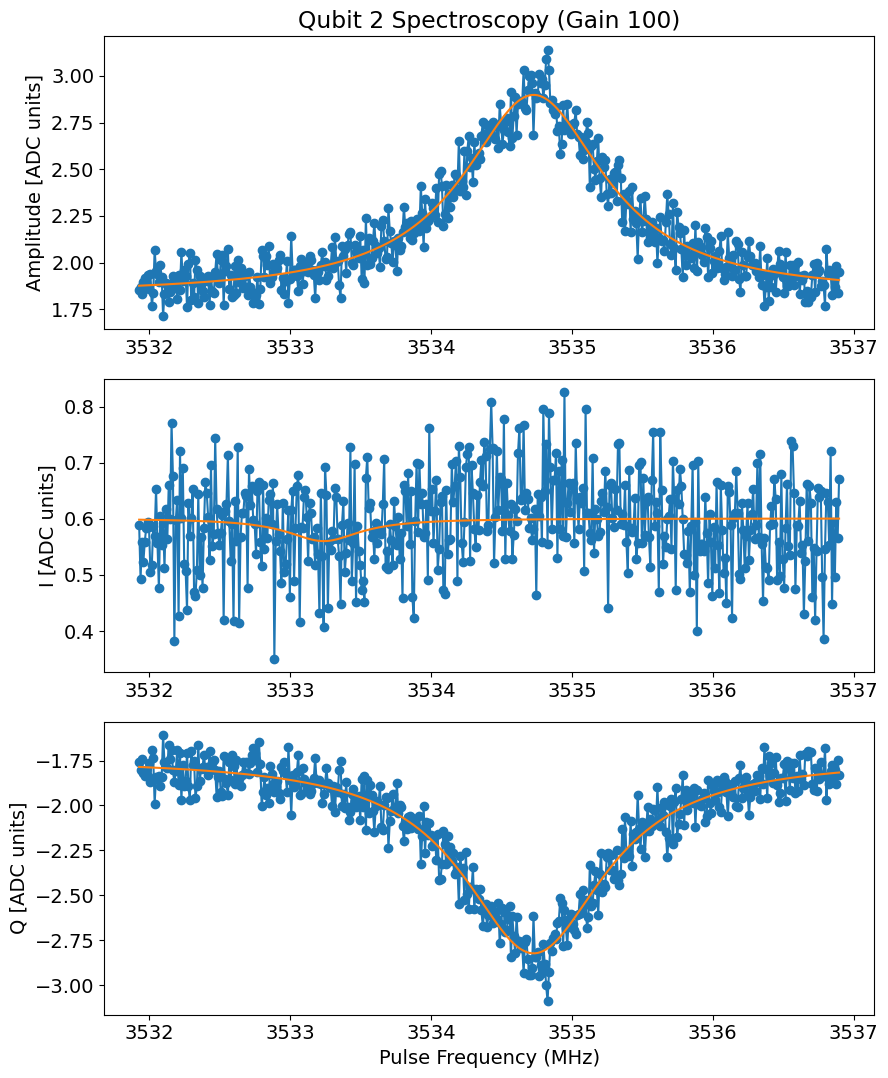

In [42]:
# # TESTING
# qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit1.h5')
# temp_data['avgi'] = temp_data['amps']
# data = qspec.analyze(data=temp_data, fit=True)
# qspec.display(data=data, fit=True)

qspec.analyze(fit=True, signs=[1, -1, 1])
qspec.display(fit=True, signs=[1, -1, 1])

## xxxxxxxxx TEST BELOW xxxxxxxxx

The code below automates the search process and increments the qubit frequency to sweep as long as the maximum of the qubit amplitude is below some threshold value defined by the resonator spectroscopy. This means the resonantor spectroscopy value will need to be updated so for each different qubit, the user must rerun the resonator spectroscopy. 

Or save the resonator spectroscopy into the config file??

In [344]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
span = 100
npts =150
threshold = 0.7* max(rspec.data['amps'])
increment = 100 # increase the start by 100MHz
frequency_min =  qspec.cfg.device.qubit.f_ge[qubit_i] - span/2
frequency_max =  qspec.cfg.device.qubit.f_ge[qubit_i] + span/2 + 1000

print('frequency min:', qspec.cfg.device.qubit.f_ge[qubit_i] - span/2)
print('frequency max:',  qspec.cfg.device.qubit.f_ge[qubit_i] + span/2 + 1000)

qspec.cfg.expt = dict(
    frequency_min = qspec.cfg.device.qubit.f_ge[qubit_i] - span/2, 
    start= qspec.cfg.device.qubit.f_ge[qubit_i] - span/2, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 MHz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=2, # Qubit probe constant pulse length [us]
    gain=200, # Qubit pulse gain
    pulse_type='gauss',
    qubit=qubit_i,
    )
qspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec.go(analyze=True, display=False, progress=True, save=False)
data_amps = qspec.data['amps']


# If it passes threshold, rerun the experiment but with a finer sweep.

if max(data_amps) >= threshold:
    print('Threshold achieved, doing a finer scan')
    span = 2
    npts = 200
    qspec.cfg.expt = dict(
        step=span/npts, # min step ~1 MHz
        start = frequency_min, # resonator frequency to be mixed up [MHz]
        expts=npts, # Number of experiments stepping from start
        reps=100, # Number of averages per point
        rounds=20, # Number of start to finish sweeps to average over
        length=2, # Qubit probe constant pulse length [us]
        gain=200, # Qubit pulse gain
            # length=0.1, # Qubit probe constant pulse length [us]
            # gain=10, # Qubit pulse gain
            # pulse_type='const',
        pulse_type='gauss',
    qubit=qubit_i,
    )
    qspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
    qspec.go(analyze=True, display=False, progress=True, save=False)
    qspec.analyze(fit=True, signs=[1, -1, 1])
    qspec.display(fit=True, signs=[1, -1, 1])
    print('Qubit Frequency found!')


else: 
    qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
    )

    frequency_min =  qspec.cfg.device.qubit.f_ge[qubit_i] - span/2
    frequency_max =  qspec.cfg.device.qubit.f_ge[qubit_i] + span/2 + 1000

    while frequency_min <= frequency_max:
        if max(data_amps) >= threshold:
           print('Threshold achieved, doing a finer scan')
           span = 2
           npts = 200
           qspec.cfg.expt = dict(
                step=span/npts, # min step ~1 MHz
                start = frequency_min, # resonator frequency to be mixed up [MHz]
                expts=npts, # Number of experiments stepping from start
                reps=100, # Number of averages per point
                rounds=20, # Number of start to finish sweeps to average over
                length=2, # Qubit probe constant pulse length [us]
                gain=200, # Qubit pulse gain
                # length=0.1, # Qubit probe constant pulse length [us]
                # gain=10, # Qubit pulse gain
                # pulse_type='const',
                pulse_type='gauss',
                qubit=qubit_i,
            )
           qspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
           qspec.go(analyze=True, display=False, progress=True, save=False)
           qspec.analyze(fit=True, signs=[1, -1, 1])
           qspec.display(fit=True, signs=[1, -1, 1])
           print('Qubit Frequency found!')
           break  

        qspec = meas.PulseProbeSpectroscopyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"qubit_spectroscopy_qubit{qubit_i}",
        config_file=config_path,
     )

        frequency_min = frequency_min + increment
        print('current frequency:', frequency_min)
        qspec.cfg.expt = dict(
            #frequency_min = qspec.cfg.device.qubit.f_ge[qubit_i] - span/  2, 
    
            start=frequency_min, # resonator frequency to be mixed up [MHz]
            # start=qspec.cfg.device.qubit.f_ge[qubit_i]-0.95*span, # resonator frequency to be mixed up [MHz]
            # start=4780,
            step=span/npts, # min step ~1 MHz
            expts=npts, # Number of experiments stepping from start
            reps=100, # Number of averages per point
            rounds=20, # Number of start to finish sweeps to average over
            length=2, # Qubit probe constant pulse length [us]
            gain=200, # Qubit pulse gain
            # length=0.1, # Qubit probe constant pulse length [us]
            # gain=10, # Qubit pulse gain
            # pulse_type='const',
            pulse_type='gauss',
            qubit=qubit_i,
        )
    
        qspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
        qspec.go(analyze=True, display=False, progress=True, save=False)
        data_amps = qspec.data['amps']

    if frequency_min == frequency_max:    
        print('Qubit frequnecy not found. Try adjusting the minimum frequency.')    


frequency min: 3255.0044402365666
frequency max: 4355.004440236567


  0%|          | 0/20 [00:00<?, ?it/s]

current frequency: 3355.0044402365666


  0%|          | 0/20 [00:00<?, ?it/s]

current frequency: 3455.0044402365666


  0%|          | 0/20 [00:00<?, ?it/s]

current frequency: 3555.0044402365666


  0%|          | 0/20 [00:00<?, ?it/s]

current frequency: 3655.0044402365666


  0%|          | 0/20 [00:00<?, ?it/s]

current frequency: 3755.0044402365666


  0%|          | 0/20 [00:00<?, ?it/s]

current frequency: 3855.0044402365666


  0%|          | 0/20 [00:00<?, ?it/s]

current frequency: 3955.0044402365666


  0%|          | 0/20 [00:00<?, ?it/s]

current frequency: 4055.0044402365666


  0%|          | 0/20 [00:00<?, ?it/s]

current frequency: 4155.004440236567


  0%|          | 0/20 [00:00<?, ?it/s]

current frequency: 4255.004440236567


  0%|          | 0/20 [00:00<?, ?it/s]

current frequency: 4355.004440236567


  0%|          | 0/20 [00:00<?, ?it/s]

current frequency: 4455.004440236567


  0%|          | 0/20 [00:00<?, ?it/s]

In [269]:
qspec.save_data()

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00000_qubit_spectroscopy_qubit0.h5


## Length Rabi

Measures Rabi oscillations by sweeping over the duration of the qubit drive pulse. This is a preliminary measurement to prove that we see Rabi oscillations. This measurement is followed up by the Amplitude Rabi experiment below.


In [46]:
qubit_i = 3
soc.cycles2us(1, gen_ch=0)

0.0023251488095238095

In [47]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)

lengthrabi.cfg.expt = dict(
    start =  0.0025, 
    #start = 0.1915776006886583,
    #start=soc.cycles2us(1), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us] this is the samllest possible step size (size of clock cycle)
    #step = 0.01, 
    #step = 0.001, 
    expts= 100, #51 
    reps=2000, #2000
    gain=1000, # qubit gain [DAC units],
    #gain=lengthrabi.cfg.device.qubit.pulses.pi_ge.gain[qubit_i],
    pulse_type='gauss',
    # pulse_type='const',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
    # qubits=[3,1],
)
# lengthrabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(lengthrabi.cfg)
# lengthrabi.im[lengthrabi.cfg.aliases.soc].reset()
import Pyro4.util
try:
    lengthrabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [120.68761341486444, 187.33213316885298, 168.99158742583094, 179.34115523113738, 98.33856218592895, 176.6749889858168], 'f_ge': [3306.331430281384, 3559.5989142350372, 3534.728059761181, 3542.27326403314, 3270.5822861523375, 3791.61038088935], 'f_ef': [4000, 4000, 4000, 4000, 4000, 4000], 'f_EgGf': [2000, 2000, 2000, 2000, 2000, 2000], 'pulses': {'pi_ge': {'gain': [1017, 1021, 986, 972, 975, 989], 'sigma': [0.08795696668925942, 0.12184260004276688, 0.10965835304102353, 0.1420366397101421, 0.08979016287487021, 0.1977267386232169], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000, 10000, 1000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'gain': [6000, 6000, 6000, 5000, 3000, 3000], 'phase': [0, 0, 0, 0, 0, 0], 'threshold': [0, 0, 0, 0, 0, 0], 'readout_length': [5, 5, 5, 5, 5,

  0%|          | 0/100 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 208.52363636363634, which is out of bounds 0.4388571428571429 to 65.82857142857142. Instead init to 33.133714285714284
Attempted to init fitparam 1 to 73.8521212121212, which is out of bounds 0.4388571428571429 to 65.82857142857142. Instead init to 33.133714285714284
Attempted to init fitparam 1 to 73.8521212121212, which is out of bounds 0.4388571428571429 to 65.82857142857142. Instead init to 33.133714285714284
Decay from avgi [us] 0.06835937500000001
Pi length from avgi data [us]: 0.006349188670897527
	Pi/2 length from avgi data [us]: 0.0031745943354487636

Decay from avgq [us] 1.138864586495938
Pi length from avgq data [us]: 0.14281583379905646
Pi/2 length from avgq data [us]: 0.07140791689952823


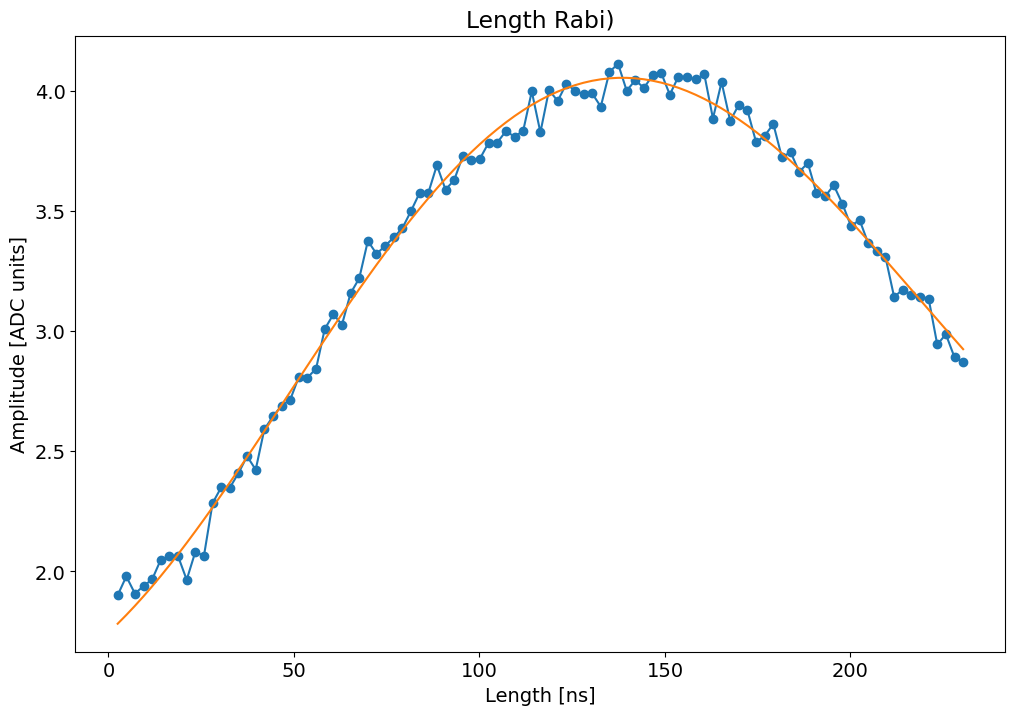

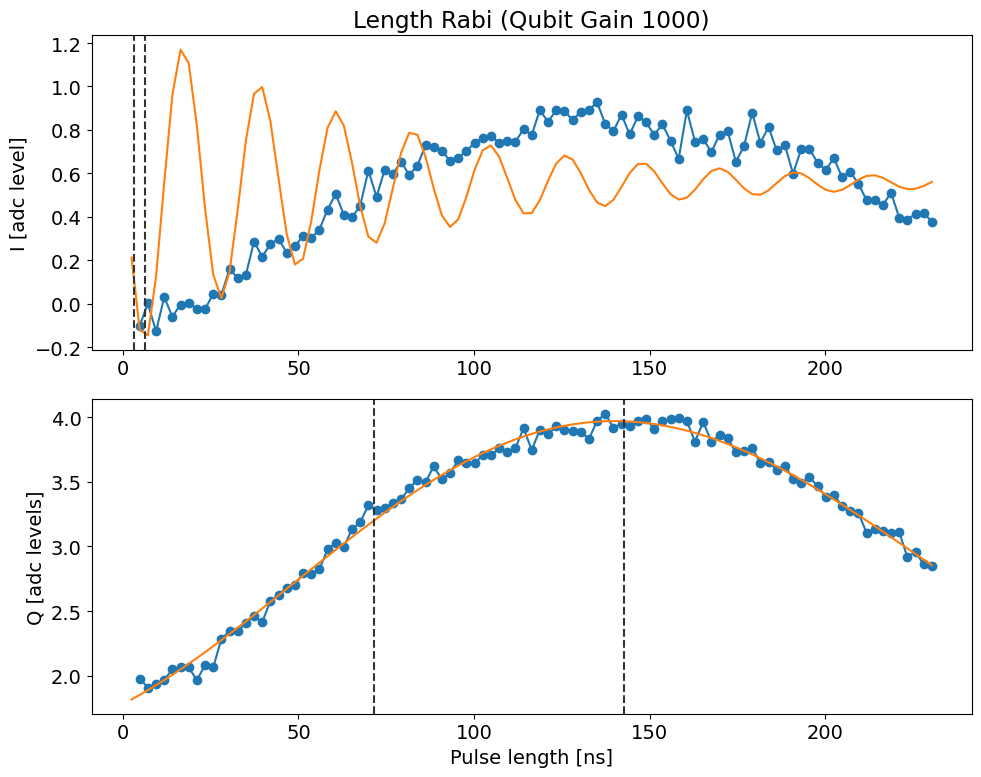

In [48]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

lengthrabi.analyze(fit=True)
lengthrabi.display(fit=True)

In [141]:
lengthrabi.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00001_length_rabi_qubit3.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_221215\\00001_length_rabi_qubit3.h5'

## Amplitude Rabi

Measures Rabi oscillations by sweeping over the amplitude of the qubit drive pulse, which is a Gaussian pulse with sigma set by <code>cfg.device.qubiti.pulses.pi_ge.sigma</code>. We measure the $\pi$ pulse amplitude which are used in subsequent experiments to control the qubit, which should be stored in <code>cfg.device.qubiti.pulses.pi_ge.gain</code>.

In [52]:
qubit_i = 3

In [53]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)

# span = 1500
# span = 3000
span = 3000
npts = 200
    
amprabi.cfg.expt = dict(
    # start=0, # qubit gain [dac level]
    # start=2047,
    start=100,
    step=int(span/npts), # [dac level]
    # step=0, # [dac level]
    expts=npts,
    reps=100,
    rounds=10,
    # sigma_test=0.123, # gaussian sigma for pulse length - overrides config [us]
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
    pulse_type='gauss',
    # pulse_type='const',
)

# amprabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(amprabi.cfg)

import Pyro4.util
try:
    amprabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [120.68761341486444, 187.33213316885298, 168.99158742583094, 179.34115523113738, 98.33856218592895, 176.6749889858168], 'f_ge': [3306.331430281384, 3559.5989142350372, 3534.728059761181, 3542.27326403314, 3270.5822861523375, 3791.61038088935], 'f_ef': [4000, 4000, 4000, 4000, 4000, 4000], 'f_EgGf': [2000, 2000, 2000, 2000, 2000, 2000], 'pulses': {'pi_ge': {'gain': [1017, 1021, 986, 972, 975, 989], 'sigma': [0.08795696668925942, 0.12184260004276688, 0.11043317188279761, 0.14281583379905646, 0.08979016287487021, 0.1977267386232169], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000, 10000, 1000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'gain': [6000, 6000, 6000, 5000, 3000, 3000], 'phase': [0, 0, 0, 0, 0, 0], 'threshold': [0, 0, 0, 0, 0, 0], 'readout_length': [5, 5, 5, 5, 5

  0%|          | 0/10 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 969
	Pi/2 gain from amps data [dac units]: 484
Pi gain from avgi data [dac units]: 957
	Pi/2 gain from avgi data [dac units]: 478
Pi gain from avgq data [dac units]: 968
	Pi/2 gain from avgq data [dac units]: 484


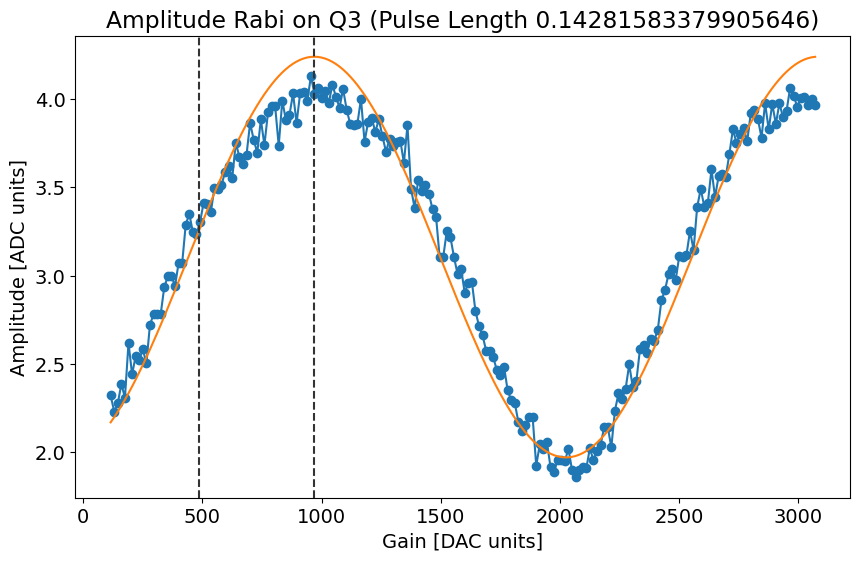

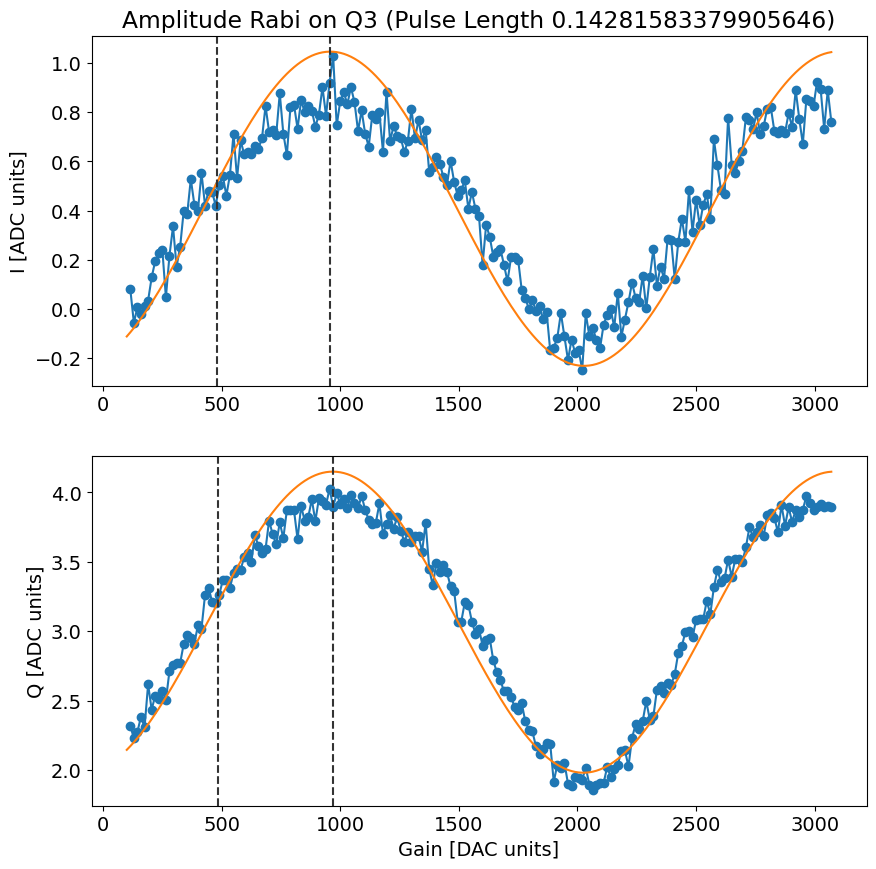

In [54]:
# # TESTING
# amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit2.h5')
# data = amprabi.analyze(data=temp_data, fit=True)
# amprabi.display(data=data, fit=True)

amprabi.analyze(fit=True)
amprabi.display(fit=True)

In [71]:
amprabi.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220801\00000_amp_rabi_qubit1.h5


## Amplitude rabi qubit frequency sweep (chevron)

In [747]:
qubit_i = 0

In [750]:
amprabichev = meas.AmplitudeRabiChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit_chevron{qubit_i}",
    config_file=config_path,
)

span_gain = 5000
npts_gain = 51
#span_gain = 0
#npts_gain = 1

span_f = 8
npts_f = 20

amprabichev.cfg.expt = dict(
    start_f=amprabichev.cfg.device.qubit.f_ge[qubit_i]-span_f/2,
    # start_f=amprabichev.cfg.device.qubit.f_Q1_ZZ[0]-span_f/2,
    # start_f=amprabichev.cfg.device.qubit.f_ef[qubit_i]-span_f/2,
    step_f=span_f/(npts_f-1),
    expts_f=npts_f,
    # start_gain=0, # qubit gain [dac level]
    start_gain= amprabichev.cfg.device.qubit.pulses.pi_ge.gain[qubit_i],
    step_gain=int(span_gain/npts_gain), # [dac level]
    expts_gain=npts_gain,
    reps=50,
    rounds=10,
    # sigma_test=0.2, # gaussian sigma for pulse length - overrides config [us]
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
    pulse_type='gauss',
)

# amprabichev.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

print(amprabichev.cfg)

amprabichev.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [114.60819807329304, 145.32072588810556, 168.99158742583094, 179.34115523113738, 98.33856218592895, 176.6749889858168], 'f_ge': [3306.331430281384, 3559.5989142350372, 3339.61876102317, 3542.27326403314, 3270.5822861523375, 3791.61038088935], 'f_ef': [4000, 4000, 4000, 4000, 4000, 4000], 'f_EgGf': [2000, 2000, 2000, 2000, 2000, 2000], 'pulses': {'pi_ge': {'gain': [1017, 1021, 986, 972, 975, 989], 'sigma': [0.08795696668925942, 0.12184260004276688, 0.10965835304102353, 0.1420366397101421, 0.08979016287487021, 0.1977267386232169], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000, 10000, 1000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'gain': [6000, 8000, 6000, 5000, 3000, 3000], 'phase': [0, 0, 0, 0, 0, 0], 'threshold': [0, 0, 0, 0, 0, 0], 'readout_length': [5, 5, 5, 5, 5, 

  0%|          | 0/20 [00:00<?, ?it/s]

gauss
gauss
gauss
gauss
gauss
gauss
gauss
gauss
gauss
gauss
gauss
gauss
gauss
gauss
gauss
gauss
gauss
gauss
gauss
gauss


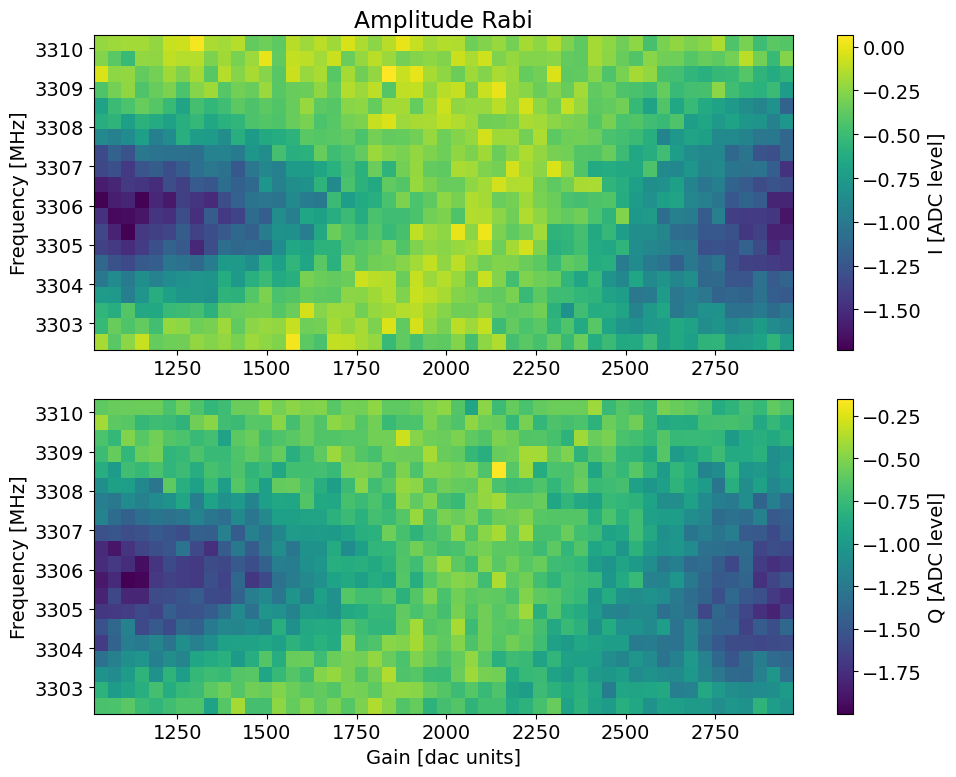

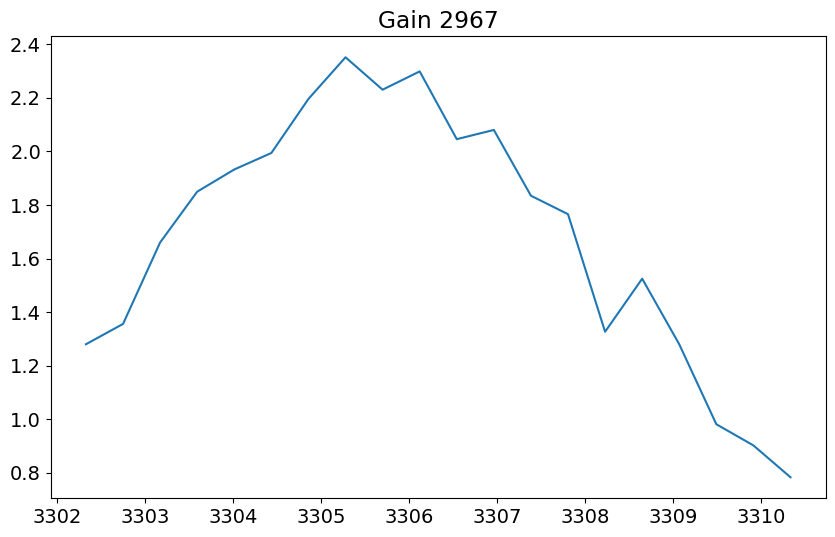

In [751]:
# # TESTING
# temp_data_file = '/home/xilinx/jupyter_notebooks/_experiment/20211215_LL_StandardCandle1/data/00000_power_sweep_resonator_spectroscopy_qubit2.h5'
# with SlabFile(temp_data_file) as a:
#     temp_data = dict(
#         amps=np.asarray(a['amps']),
#         gainpts=np.asarray(a['gain']),
#         fpts=np.asarray(a['freq']),
#     )

# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

amprabichev.analyze()
amprabichev.display()

In [ ]:
amprabichev.save_data()

## Single Shot

Measures the single shot readout fidelity of the system. We acquire single shot (I, Q) readout values by first preparing the qubit in its ground (blue dots) a certain number of times and then preparing the qubit in its excited state (red dots) the same number of times. We then extract two parameters which are used to optimize the associated readout fidelity: the rotation angle of the IQ blobs and the threshold that classifies the two qubit states (ground and excited). The two output parameters should be stored in <code>cfg.device.readouti.phase</code> and <code>cfg.device.readouti.threshold</code>.

Note that this experiment already assumes that you have found your qubit frequency and $\pi$ pulse amplitude. Every time you reset the QICK firmware the single shot angle and threshold changes. So, this experiment is used to calibrate any experiment below that uses single shot data (such as the Active Reset experiment).

In [18]:
qubit_i = 0

In [38]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)

shot.cfg.expt = dict(
    reps=10000,
    check_f=False,
    # qubit=1,
    qubit=qubit_i,
)

# shot.cfg.device.readout.frequency[qubit_i]=-813.408 + 0.05
#shot.cfg.device.readout.gain=1000
#shot.cfg.device.qubit.pulses.gain= 500
shot.cfg.device.readout.readout_length = 5 # [us]
shot.cfg.device.readout.relax_delay = 500 # Wait time between experiments [us]

shot.go(analyze=False, display=False, progress=True, save=False)

Could not load config.


Traceback (most recent call last):
  File "C:\_Lib\python\slab\experiment.py", line 66, in load_config
    self.cfg = AttrDict(yaml.safe_load(fid))
  File "C:\_Lib\python\slab\datamanagement.py", line 536, in __init__
    self.__setitem__(key, value[key])
  File "C:\_Lib\python\slab\datamanagement.py", line 543, in __setitem__
    super(AttrDict,self).__setitem__(key, value)
TypeError: super(type, obj): obj must be an instance or subtype of type


AttributeError: 'NoneType' object has no attribute 'expt'

Unrotated:
Ig 0.05692908262849707 +/- 2.290369203162786 	 Qg -0.043916720884840596 +/- 2.3018964973858265 	 Amp g 0.07189992226838107
Ie -0.012687052700065062 +/- 2.3362788530010583 	 Qe -0.009433962264150945 +/- 2.3058071548786034 	 Amp e 0.01581015339001024
Rotated:
Ig -0.037016078461581864 +/- 2.290369203162786 	 Qg 0.03604892545842722 +/- 2.3018964973858265 	 Amp g 0.05166928576418709
Ie 0.027728685256640663 +/- 2.3362788530010583 	 Qe 0.009701498152770466 +/- 2.3058071548786034 	 Amp e 0.029376845515985035


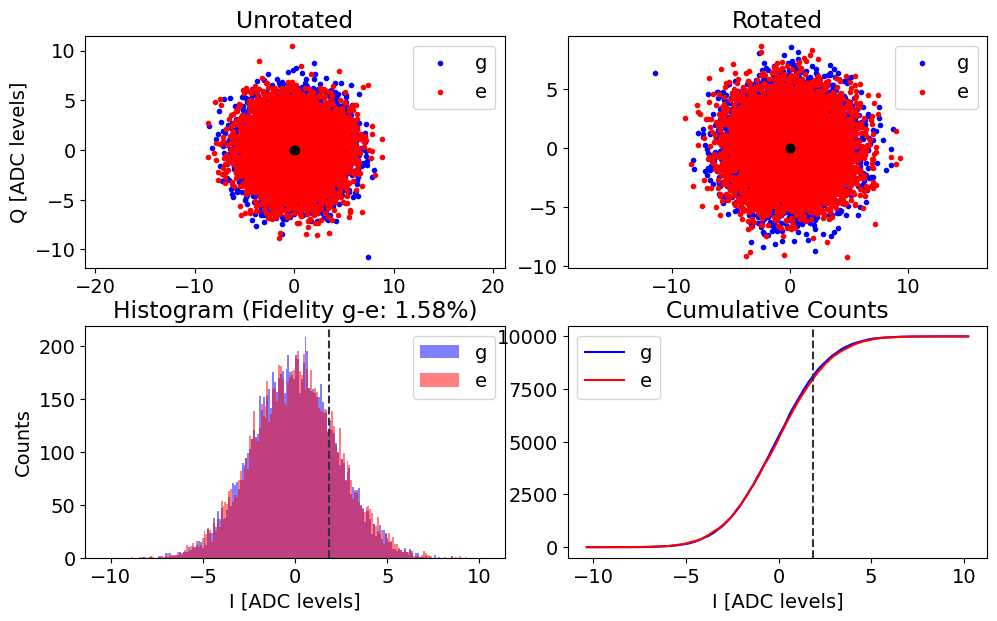

ge fidelity (%): 1.5800790039501977
rotation angle (deg): -153.6495387540514
threshold ge: 1.8576575234281503


In [28]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

shot.analyze(verbose=False)
shot.display(verbose=True, plot_f=False)

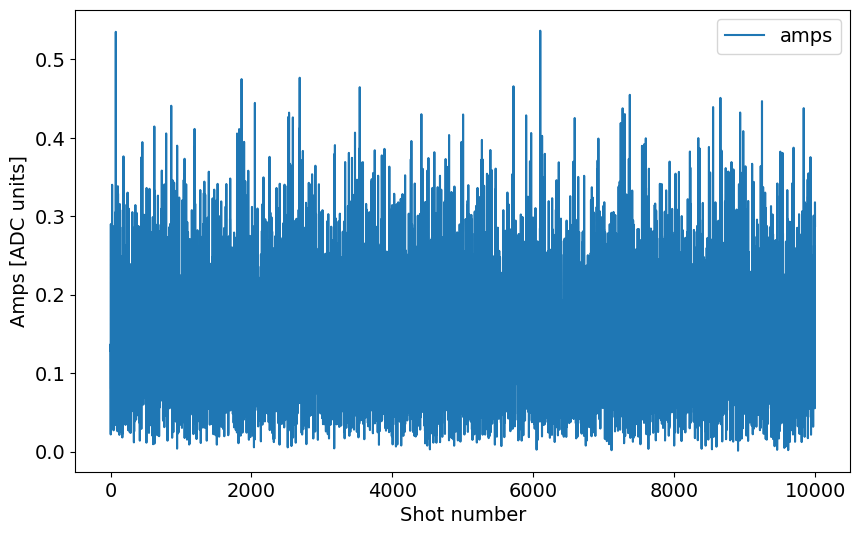

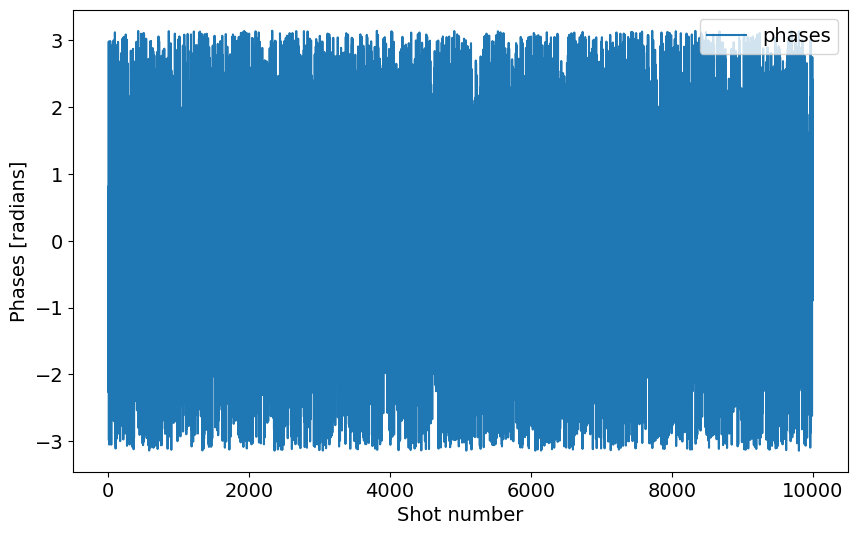

In [163]:
# Checking for drift vs. shot number

data = shot.data
i = data['Ig']
q = data['Qg']
amps = np.abs(i+1j*q)
phases = np.angle(i+1j*q)

plt.plot(amps, label='amps')
plt.ylabel('Amps [ADC units]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

plt.plot(phases, label='phases')
plt.ylabel('Phases [radians]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

In [482]:
shot.save_data()

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00000_single_shot_qubit5.h5


Single shot drift

In [483]:
import time

Igs = []
Qgs = []
Ies = []
Qes = []
angles = []

drift_meas_time = 10*60

start_time = time.time()
elapsed_time = 0
meas_times = []
for i in tqdm(range(20)):
# for i in tqdm(range(3)):
    shot = meas.HistogramExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"single_shot_qubit{qubit_i}",
        config_file=config_path,
    )

    shot.cfg.expt = dict(
        reps=20000,
        check_f=False,
        qubit=qubit_i,
    )

    # shot.cfg.device.readout.frequency=-82.015-0.54
    shot.cfg.device.readout.gain=0.75
    # shot.cfg.device.readout.readout_length = 10 # [us]
    # shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
    # print(shot.cfg)

    shot.go(analyze=False, display=False, progress=False, save=False)
    elapsed_time = time.time() - start_time

    shot.analyze(verbose=False)

    Ig = np.average(shot.data['Ig'])
    Qg = np.average(shot.data['Qg'])
    Ie = np.average(shot.data['Ie'])
    Qe = np.average(shot.data['Qe'])
    angle = shot.data['angle']
    # print('Ig', Ig, 'Qg', Qg, 'Ie', Ie, 'Qe', Qe, 'angle', angle)

    Igs.append(Ig)
    Qgs.append(Qg)
    Ies.append(Ie)
    Qes.append(Qe)
    angles.append(angle)

    meas_times.append(elapsed_time)
    if elapsed_time > drift_meas_time: break
    time.sleep(30)

    

  0%|          | 0/20 [00:05<?, ?it/s]


TypeError: unsupported operand type(s) for <<: 'float' and 'int'

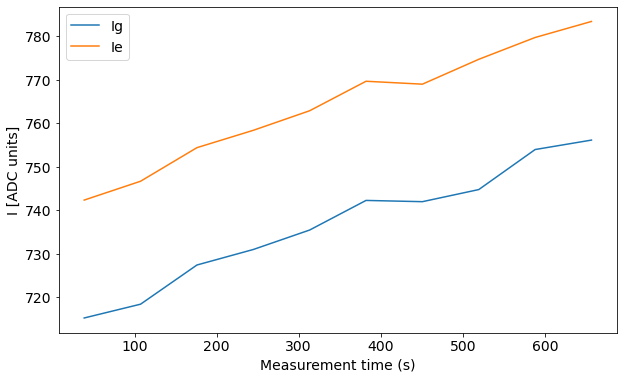

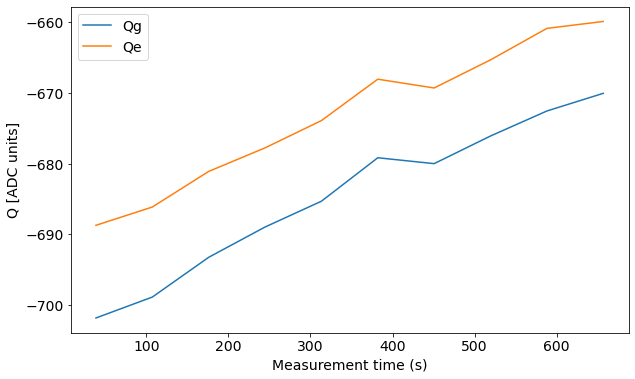

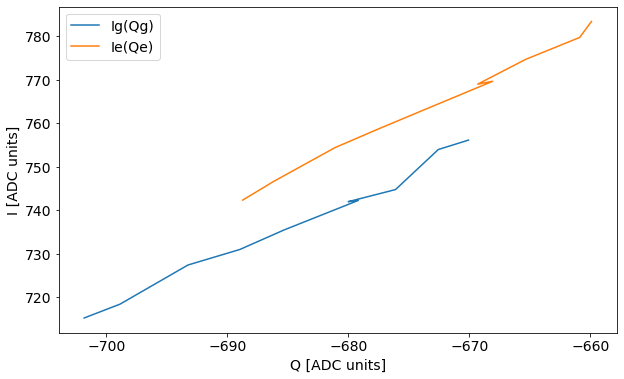

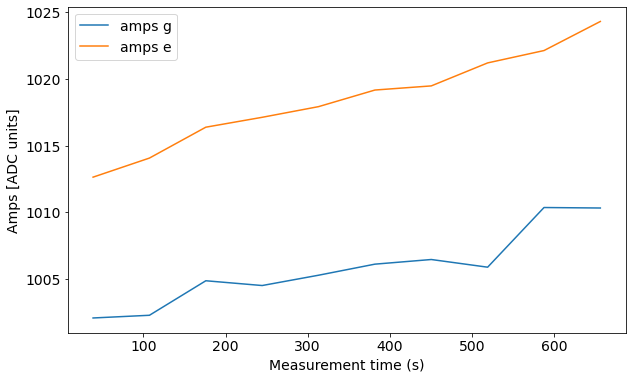

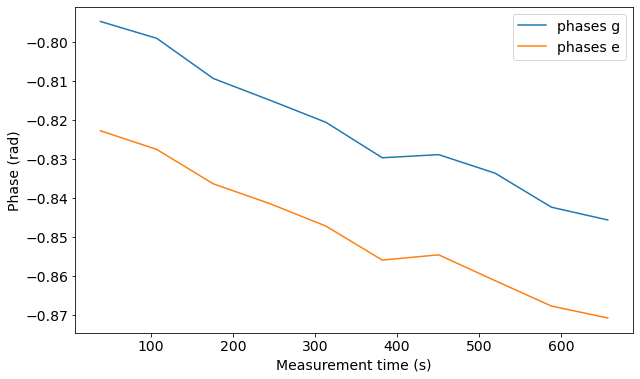

In [391]:
Igs = np.array(Igs)
Qgs = np.array(Qgs)
Ies = np.array(Ies)
Qes = np.array(Qes)
phase_gs = arctan(Igs/Qgs)
phase_es = arctan(Ies/Qes)
amps_gs = np.sqrt(Igs**2 + Qgs**2)
amps_es = np.sqrt(Ies**2 + Qes**2)

plt.plot(meas_times, Igs, label='Ig')
plt.plot(meas_times, Ies, label='Ie')
plt.ylabel('I [ADC units]')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()

plt.plot(meas_times, Qgs, label='Qg')
plt.plot(meas_times, Qes, label='Qe')
plt.ylabel('Q [ADC units]')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()

plt.plot(Qgs, Igs, label='Ig(Qg)')
plt.plot(Qes, Ies, label='Ie(Qe)')
plt.ylabel('I [ADC units]')
plt.xlabel('Q [ADC units]')
plt.legend()
plt.show()

plt.plot(meas_times, amps_gs, label='amps g')
plt.plot(meas_times, amps_es, label='amps e')
plt.ylabel('Amps [ADC units]')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()

plt.plot(meas_times, phase_gs, label='phases g')
plt.plot(meas_times, phase_es, label='phases e')
plt.ylabel('Phase (rad)')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()


### Single shot/readout optimization

In [484]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 1 # MHz
npts_f = 5

span_gain = 0.07
# npts_gain = 2
npts_gain = 7

span_len = 9 # us
# npts_len = 2
npts_len = 3

shotopt.cfg.expt = dict(
    reps=100000,
    qubit=qubit_i,

    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.5*span_f,
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i] - 0.5*span_gain),
    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.01,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain,

    start_len=3,
    step_len=span_len/npts_len,
    expts_len=npts_len,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 50, 50, 50, 50, 50], 'f_ge': [3299.0715860779806, 3561.404258413697, 3344.034437409846, 3344.1703355301224, 3270.3599353217137, 3791.030296251583], 'f_ef': [4000, 4000, 4000, 4000, 4000, 4000], 'f_EgGf': [2000, 0, 2000, 2000, 2000, 2000], 'pulses': {'pi_ge': {'gain': [20000, 20000, 20000, 20000, 20000, 20000], 'sigma': [0.1551350708243052, 0.1915776006886583, 0.20274089356743963, 0.24948083608750932, 0.16725281979805606, 0.2874400547035771], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000, 1000, 1000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'gain': [500, 500, 500, 500, 500, 500], 'phase': [0, 0, 0, 0, 0, 0], 'threshold': [0, 0, 0, 0, 0, 0], 'readout_length': [20, 20, 20, 20, 20, 20], 'relax_delay': [300, 300, 300, 300, 300, 300], 'frequency': [7094.975, 7127.325, 

  0%|          | 0/5 [00:00<?, ?it/s]

TypeError: ufunc 'left_shift' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [63]:
shotopt.analyze()
print(shotopt.data['fid'])

(4, 6, 2)
[-805.55554475 -805.35554475 -805.15554475 -804.95554475 -804.75554475]
[0.01 0.02 0.03 0.04 0.05 0.06 0.07]
[3. 6. 9.]
Max fidelity 0.14115141151411514
Set params: 
 angle (deg) 79.27975364474388 
 threshold -74.77681231100001 
 freq [Mhz] -804.7555447534925 
 gain [dac units] 0.06999999999999999 
 readout length [us] 9.0
[[[0.00840008 0.01332007 0.00761008]
  [0.0196801  0.0201102  0.02307012]
  [0.03011015 0.02903029 0.02637013]
  [0.03112016 0.03297016 0.03285016]
  [0.03341017 0.03753019 0.04184021]
  [0.03855039 0.03842019 0.03890039]
  [0.04129021 0.04111021 0.03618018]]

 [[0.03064015 0.03299016 0.03118016]
  [0.03923039 0.04150042 0.04435044]
  [0.04181042 0.04555023 0.04756024]
  [0.04568023 0.05172026 0.04778024]
  [0.05450027 0.06252031 0.05771087]
  [0.0604203  0.05873059 0.06262031]
  [0.06284031 0.05775029 0.06450032]]

 [[0.04171021 0.04239021 0.04251021]
  [0.07371074 0.08122081 0.08335083]
  [0.06460032 0.06747034 0.06370032]
  [0.05880029 0.05490027 0.05565

In [59]:
shotopt.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00001_single_shot_opt_qubit1.h5


## $T_1$

Measures the qubit T1 characteristic decay time by preparing the qubit in its excited state with a $\pi$ pulse followed by a variable delay ($\tau$) before measuring the qubit's state. This exponential decay curve can be fitted in post-processing to obtain the qubit T1 time.

In [81]:
qubit_i = 0

In [82]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)

span = 600
npts = 100

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=100,
    rounds=10,
    qubit=qubit_i,
)

t1.cfg.device.readout.relax_delay = span # Wait time between experiments [us]

print(t1.cfg)

t1.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [120.68761341486444, 187.33213316885298, 85.53572444033654, 179.34115523113738, 110.78317042127422, 225.12683789068893], 'f_ge': [3306.331430281384, 3559.5989142350372, 3534.728059761181, 3542.27326403314, 3270.5822861523375, 3791.61038088935], 'f_ef': [4000, 4000, 4000, 4000, 4000, 4000], 'f_EgGf': [2000, 2000, 2000, 2000, 2000, 2000], 'pulses': {'pi_ge': {'gain': [1017, 1021, 989, 969, 975, 989], 'sigma': [0.08795696668925942, 0.12184260004276688, 0.11043317188279761, 0.14281583379905646, 0.08979016287487021, 0.1977267386232169], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000, 10000, 1000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'gain': [6000, 6000, 6000, 5000, 3000, 3000], 'phase': [0, 0, 0, 0, 0, 0], 'threshold': [0, 0, 0, 0, 0, 0], 'readout_length': [5, 5, 5, 5, 

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

Fit T1 avgi [us]: 22.868049923955287
Fit T1 avgq [us]: 10.497582144668543


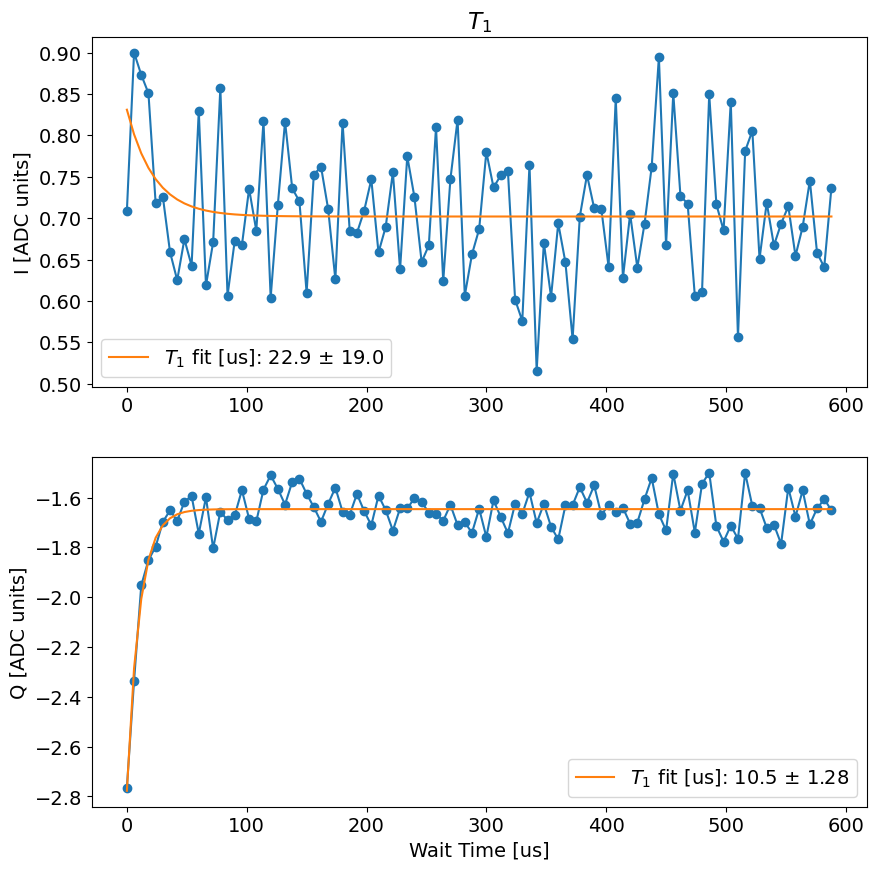

In [80]:
# # TESTING
# t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit1.h5')
# data = t1.analyze(data=temp_data, fit=True)
# t1.display(data=data, fit=True)

t1.analyze(fit=True)
t1.display()

In [938]:
t1.save_data()

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00000_t1_qubit2.h5


'c:\\_Lib\\python\\rfsoc\\elaine_rfsoc\\slab_rfsoc_expts\\data\\00000_t1_qubit2.h5'

## $T_2$ Ramsey Fringe Experiment

Measures the qubit $T_2$ Ramsey characteristic decay time by preparing the qubit in a superposition state with a  $\frac{\pi}{2}$ pulse (about X-axis) followed by a variable delay ($\tau$) before applying another $\frac{\pi}{2}$ pulse (about X-axis) with a phase advanced by $\Delta \phi = \omega * \tau$, where $\omega$ is the Ramsey frequency.

When qubit frequency is off by $\Delta$, oscillations will be observed at $\omega+\Delta$. Iterate on this experiment, adjusting the qubit frequency, until no oscillations are observed.

This exponential decay envelope can be fitted in post-processing to obtain the qubit $T_2$ Ramsey time.

In [170]:
soc.cycles2us(10)

0.023251488095238096

In [83]:
qubit_i = 0

In [174]:
t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)

t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(10)/10, # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    #step= 0.005, # [us]
    expts= 10000,
    ramsey_freq= 0.1, # 2 [MHz]
    reps=100, #100
    rounds=10, #20
    qubits=[qubit_i],
    # qubits=[1, 0], # qZZ, qTest
    checkZZ=False,
    checkEF=False,
)
# t2r.cfg.device.readout.gain = 0.15
# t2r.cfg.device.readout.relax_delay = 3*t2r.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]
# t2r.cfg.device.qubit.pulses.pi_ge.gain = 4657
# t2r.cfg.device.qubit.pulses.pi_ge.sigma = 0.070

print(t2r.cfg)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [120.68761341486444, 187.33213316885298, 85.53572444033654, 179.34115523113738, 110.78317042127422, 225.12683789068893], 'f_ge': [3306.331430281384, 3559.5989142350372, 3534.728059761181, 3542.27326403314, 3270.5822861523375, 3791.61038088935], 'f_ef': [4000, 4000, 4000, 4000, 4000, 4000], 'f_EgGf': [2000, 2000, 2000, 2000, 2000, 2000], 'pulses': {'pi_ge': {'gain': [1017, 1021, 989, 969, 975, 989], 'sigma': [0.08795696668925942, 0.12184260004276688, 0.11043317188279761, 0.14281583379905646, 0.08979016287487021, 0.1977267386232169], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000, 10000, 1000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'gain': [6000, 6000, 6000, 5000, 3000, 3000], 'phase': [0, 0, 0, 0, 0, 0], 'threshold': [0, 0, 0, 0, 0, 0], 'readout_length': [5, 5, 5, 5, 

  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 0.7742214221422141, which is out of bounds 0.004301660332066414 to 0.645249049809962. Instead init to 0.3247753550710142
Attempted to init fitparam 1 to 0.7742214221422141, which is out of bounds 0.004301660332066414 to 0.645249049809962. Instead init to 0.3247753550710142
Attempted to init fitparam 1 to 0.8172337233723371, which is out of bounds 0.004301660332066414 to 0.645249049809962. Instead init to 0.3247753550710142
Current pi pulse frequency: 3306.331430281384
Fit frequency from amps [MHz]: 0.062023923916438455 +/- 0.016050375571470578
Suggested new pi pulse frequencies from fit amps [MHz]:
 	3306.3694063574676
 	3306.169406357468
T2 Ramsey from fit amps [us]: 6.974051339285715
Current pi pulse frequency: 3306.331430281384
Fit frequency from I [MHz]: 0.037959843850112626 +/- 0.02887575889676697
Suggested new pi pulse frequency from fit I [MHz]:
 	3306.3934704375342
 	3306.193470437534
T2 Ramsey from fit I [us]: 6.974051346686596
Fit frequency fro

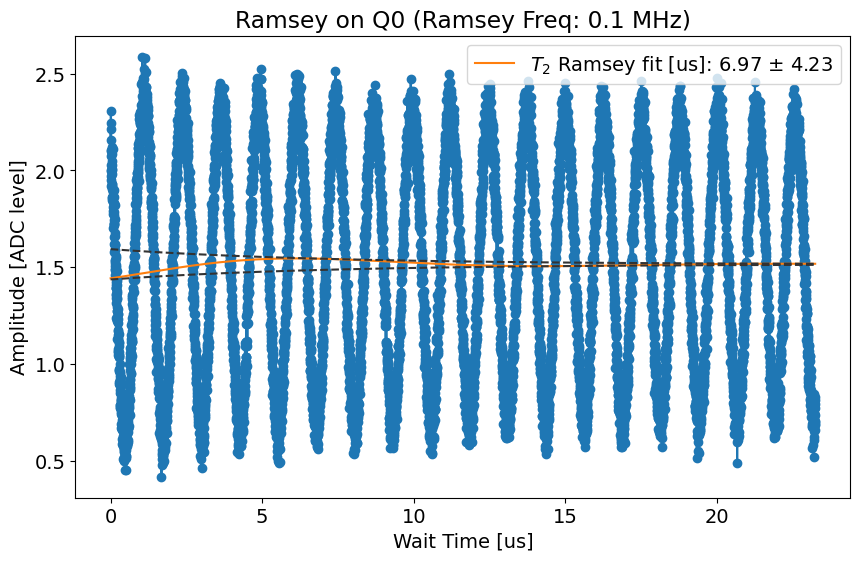

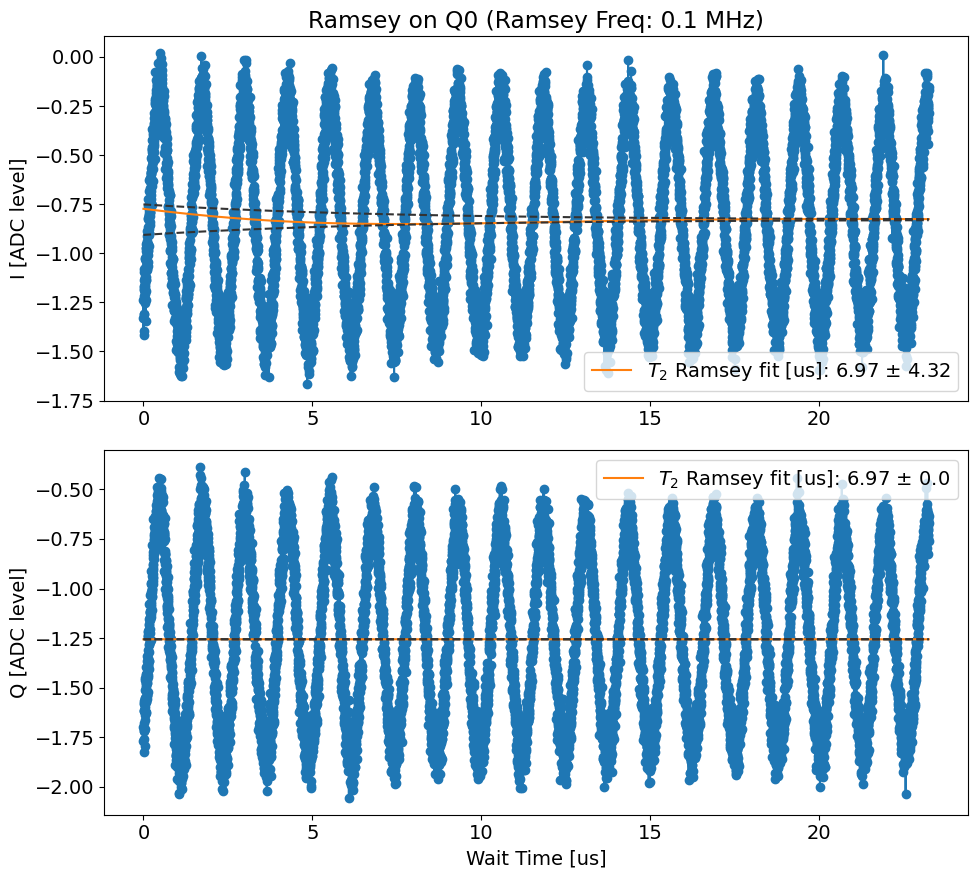

In [175]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# t2r.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.analyze(fit=True, fit_twofreq=False)
t2r.display(fit=True, fit_twofreq=False)

In [46]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# t2r.cfg.expt = dict(ramsey_freq=2, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00002_ramsey_qubit0.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_230927\\00002_ramsey_qubit0.h5'

## $T_2$ Echo

Same idea as Ramsey, but add additional $\pi$ pulses in the middle of $\tau$  which prevent the qubit from decaying as quickly.

In [166]:
0.5/soc.cycles2us(10)

17.499825

In [171]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    step=soc.cycles2us(40), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    expts=151,
    ramsey_freq=1.0, # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=True, # set either cp or cpmg to True
    cp=False, # set either cp or cpmg to True
    reps=200,
    rounds=10,
    qubit=qubit_i,
)

t2e.cfg.device.readout.relax_delay = 3*t2e.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(t2e.cfg)

t2e.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [120.68761341486444, 187.33213316885298, 85.53572444033654, 179.34115523113738, 110.78317042127422, 225.12683789068893], 'f_ge': [3306.331430281384, 3559.5989142350372, 3534.728059761181, 3542.27326403314, 3270.5822861523375, 3791.61038088935], 'f_ef': [4000, 4000, 4000, 4000, 4000, 4000], 'f_EgGf': [2000, 2000, 2000, 2000, 2000, 2000], 'pulses': {'pi_ge': {'gain': [1017, 1021, 989, 969, 975, 989], 'sigma': [0.08795696668925942, 0.12184260004276688, 0.11043317188279761, 0.14281583379905646, 0.08979016287487021, 0.1977267386232169], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000, 10000, 1000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'gain': [6000, 6000, 6000, 5000, 3000, 3000], 'phase': [0, 0, 0, 0, 0, 0], 'threshold': [0, 0, 0, 0, 0, 0], 'readout_length': [5, 5, 5, 5, 

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

Current qubit frequency: 3456.77
Fit frequency from I [MHz]: 0.9910673585254318 +/- 0.004880643696738591
T2 Echo from fit I [us]: 6.586596768882795
Fit frequency from Q [MHz]: 0.9836037935523718 +/- 0.0046141311932358445
T2 Echo from fit Q [us]: 7.939608134122287


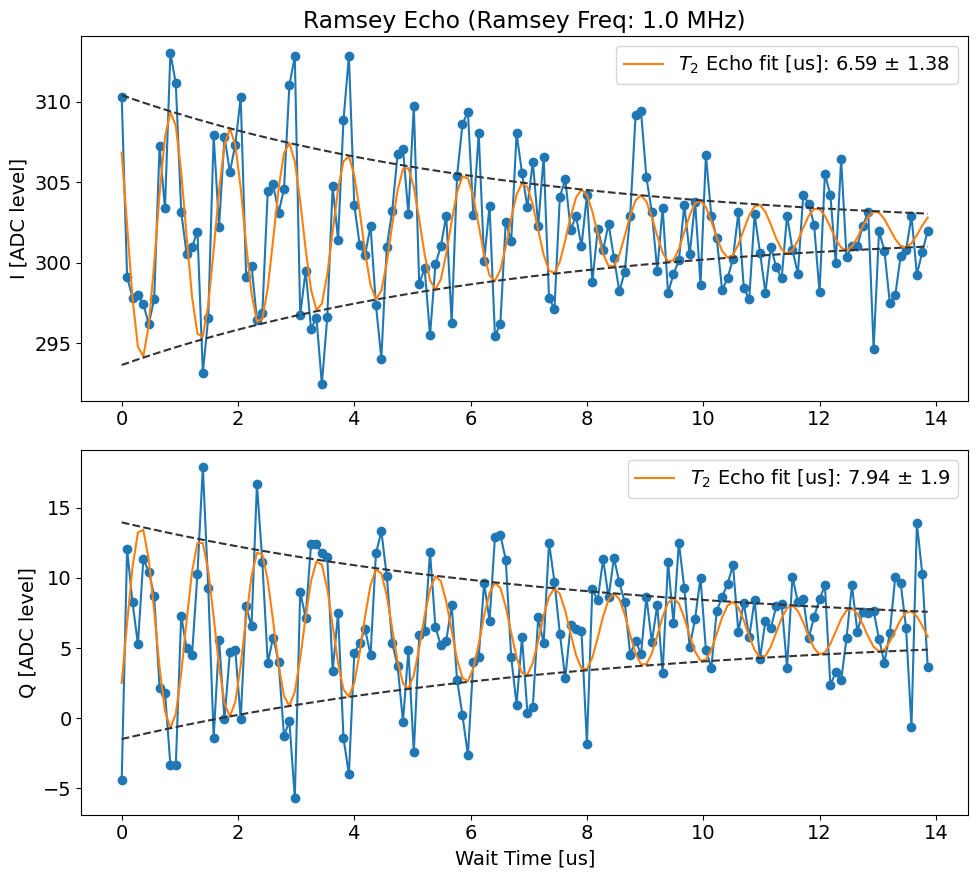

In [ ]:
# # TESTING
# t2e = meas.RamseyEchoExperiment(config_file=config_path)
# t2e.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# data = t2e.analyze(data=temp_data, fit=True)
# t2e.display(data=data, fit=True)

t2e.analyze(fit=True)
t2e.display(fit=True)

In [316]:
t2e.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_echo_qubit0.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data_220904\\00000_echo_qubit0.h5'

# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

Qubit ef frequency should be stored in <code>cfg.qubiti.f_ef</code>.

In [80]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 20
npts = 150

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    # start=qEFspec.cfg.device.qubit.f_ge[qubit_i] - 50 - span,
    # start=3435,
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=2000, # ef pulse gain
    pulse_type='gauss', # ef pulse type
    qubit=qubit_i,
)

# qEFspec.cfg.device.readout.relax_delay = 500 # Wait time between experiments [us]
# qEFspec.cfg.device.readout.gain = 0.75 # Wait time between experiments [us]
print(qEFspec.cfg)

qEFspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'f_ge': [4126.453954862341, 3454.211606121115, 4779.441948200766, 4394.480407282836], 'f_ef': [3900.453831863158, 3354.521139701014, 4590.177049031502, 4221.931929269591], 'f_Q1_ZZ': [3449.8479407210834, 0, 3453.9100412763405, 3453.7081320189013], 'f_Q_ZZ1': [4124.290504319941, 0, 4778.502356522805, 4393.211594838028], 'f_EgGf': [2681.44696031, -1, 2028.1, 2407.9], 'f_EgGf_Q': [-1, -1, 5913.75, 5163.75], 'gs': [54.233867058381975, 56.612917931142945, 42.87162116341841, 5.275712018852002, 2.7385639790041876, 6.807578931629736], 'ZZs': [0.0, -5.11947537, -0.14716401, -0.55347891, -5.11803281, 0.0, -1.17332055, -1.13249508, -0.17856354, -1.0686238, 0.0, -0.50772987, -0.64108991, -1.26309732, -0.62827282, 0.0], 'T1': [60, 60, 55, 50], 'pulses': {'pi_ge': {'gain': [28871, 26000, 2338, 2511], 'sigma': [0.015, 0.1, 0.015, 0.015], 'type': 'gauss'}, 'pi_ef': {'gain': [20742, 26000, 1633, 1669], 'sigma': [0.015, 0.1, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [99

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3363.83629283752, HWHM -0.30935743192316306
Found peak in I at [MHz] 3354.443977214433, HWHM 1.9823349464028162
Found peak in Q at [MHz] 3358.202468648115, HWHM -0.0029265967512923144


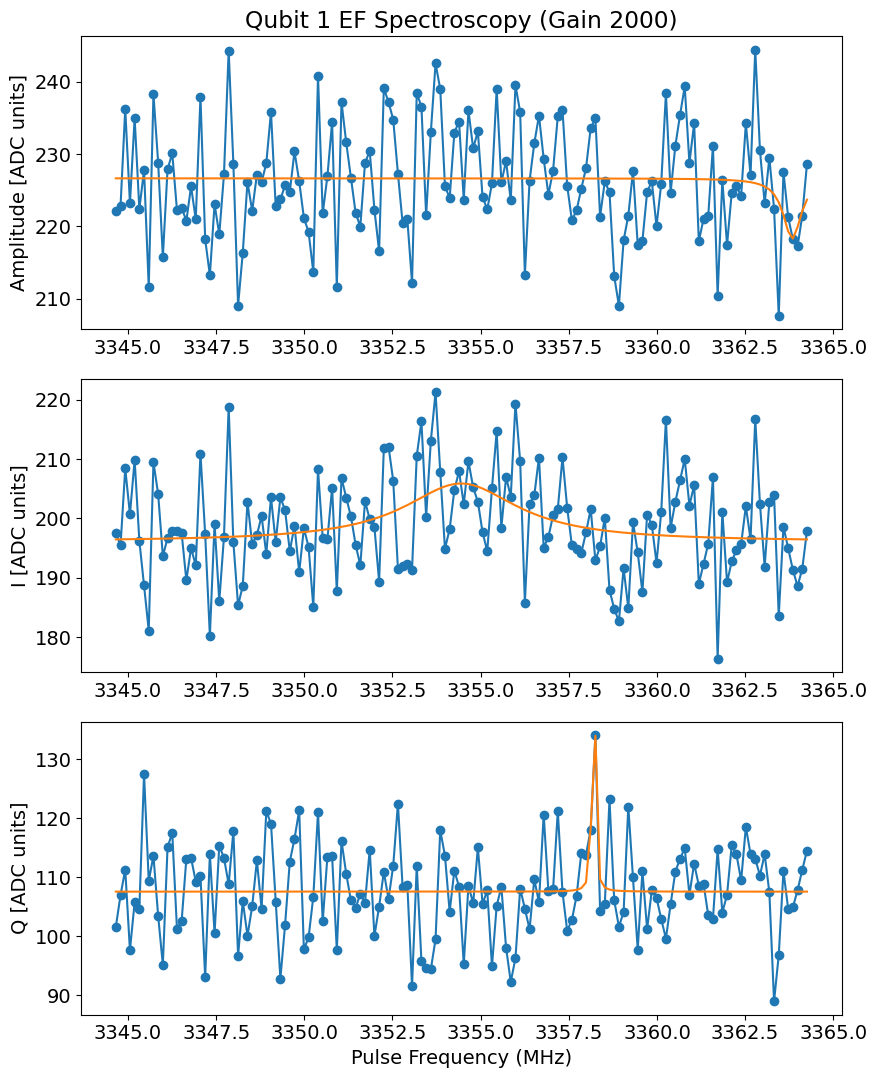

In [81]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

qEFspec.analyze(fit=True, signs=[1, -1, 1])
qEFspec.display(fit=True, signs=[1, -1, 1])

In [210]:
qEFspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00003_qubit_EF_spectroscopy_qubit3.h5


### Pulse probe EF power sweep

In [ ]:
pulseprobeEFpowspec = meas.PulseProbeEFPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"pulse_probe_ef_power_sweep_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 5
npts_f = 5

span_gain = 1000
npts_gain = 2

pulseprobeEFpowspec.cfg.expt = dict(
    start_f=pulseprobeEFpowspec.cfg.device.readout.frequency[qubit_i]-span_f/2, # Pulse frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=pulseprobeEFpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    start_gain=1,
    step_gain=int(span_gain/npts_gain), # Gain step size
    expts_gain=npts_gain, # Number experiments stepping gain from start
    reps=10,
    rounds=10, # Number averages per point
    length=10, # ef const pulse length [us]
    qubit=qubit_i,
)
pulseprobeEFpowspec.cfg.device.readout.relax_delay = 2*pulseprobeEFpowspec.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(pulseprobeEFpowspec.cfg)

pulseprobeEFpowspec.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

pulseprobeEFpowspec.analyze(lowgain=None, highgain=None)
pulseprobeEFpowspec.display()

## Length EF Rabi

In [230]:
lengthrabiEF = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabiEF_qubit{qubit_i}",
    config_file=config_path,
)

lengthrabiEF.cfg.expt = dict(
    start=soc.cycles2us(1), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0,
    expts=101,
    reps=1000,
    gain=5, # qubit gain [DAC units],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)
# lengthrabiEF.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabiEF.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/101 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 103.2192, which is out of bounds 0.43442424242424243 to 65.16363636363636. Instead init to 32.7990303030303
Attempted to init fitparam 1 to 103.2192, which is out of bounds 0.43442424242424243 to 65.16363636363636. Instead init to 32.7990303030303
Decay from avgi [us] 0.32796662339076715
Pi length from avgi data [us]: 0.037125695657721024
	Pi/2 length from avgi data [us]: 0.018562847828860512

Decay from avgq [us] 0.26565293074913116
Pi length from avgq data [us]: 0.037376930272217446
Pi/2 length from avgq data [us]: 0.018688465136108723


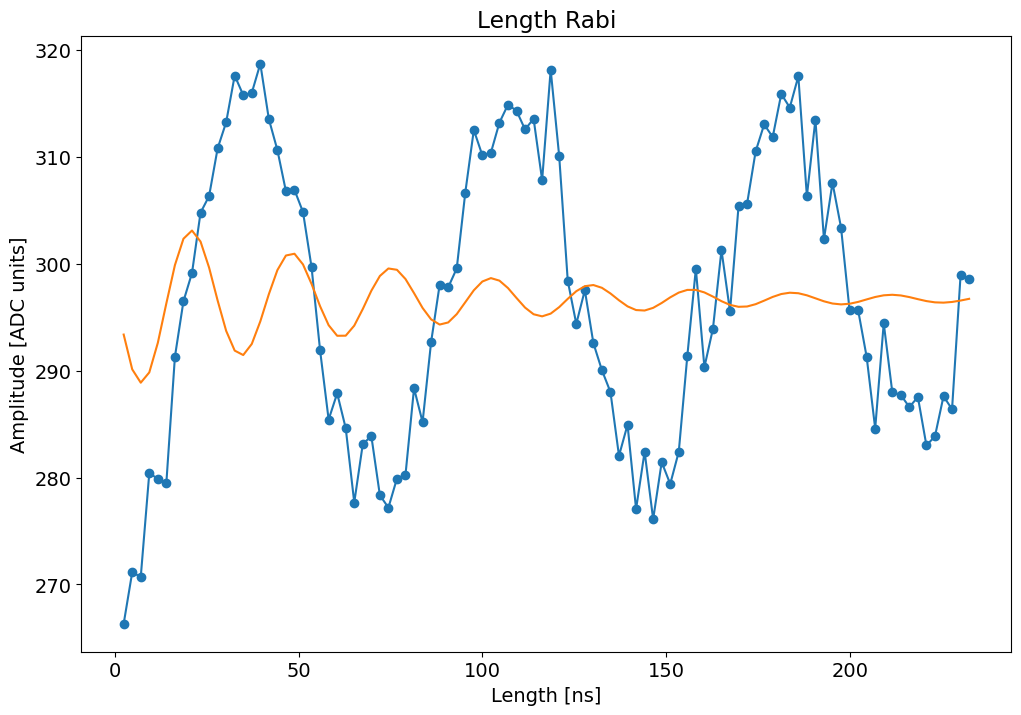

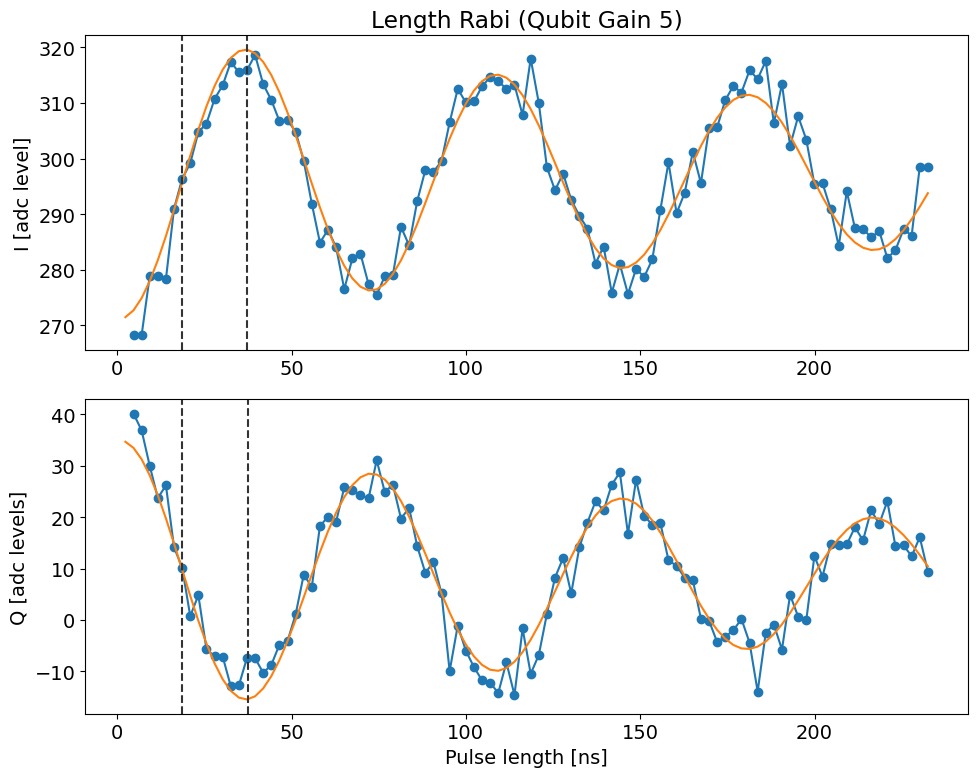

Use sigma 0.0336392372449957 for amplitude rabi EF


In [232]:
# # TESTING
# # lengthrabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabiEF.data = temp_data

lengthrabiEF.analyze(fit=True)

lengthrabiEF_fit, lengthrabiEF_fit_err = meas.fitting.get_best_fit(lengthrabiEF.data) #, fitfunc=fitter.decaysin)

lengthrabiEF.display(fit=True)
p = lengthrabiEF_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_lenEF = (1/2 - p[2]/180)/2/p[1]
else: pi_lenEF = (3/2 - p[2]/180)/2/p[1]
pi_lenEF = np.max((0.9*pi_lenEF, 0.015)) # since we run the length rabi at a < max gain

lengthrabiEF_decay = p[3]

print(f'Use sigma {pi_lenEF} for amplitude rabi EF')

In [ ]:
if save_data: saved_files.append(lengthrabi.save_data())

## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [72]:
amprabiEF = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

span = 4000
# span = 10000
npts = 101

amprabiEF.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=20,
    # sigma_test=0.013, # gaussian sigma for pulse length - default from cfg [us]
    pulse_ge=True, # set to false when measuring qubit temp
    checkEF=True,
    checkZZ=False,
    pulse_type='gauss',
    qubits=[qubit_i],
)

print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [45, 127, 55, 50], 'f_ge': [4128.575129385544, 3457.338723559245, 4782.305489871236, 4396.915066710553], 'f_Q1_ZZ': [3452.0169427371175, 3457.338723559245, 3456.1893267454375, 3456.018803727748], 'f_Q_ZZ1': [4123.341754941294, 3457.338723559245, 0, 0], 'f_ef': [3902.5097729724093, 3356.7928599815136, 4592.511526938749, 4223.758894341571], 'f_EgGf': [2681.44696031, -1, 2022.3, 2407.9], 'f_EgGf_Q': [-1, -1, 5916.8, 5168.4], 'gs': [54.34474556, 56.18845266, 43.07411448, 5.80677427, 2.37708297, 6.56997134], 'ZZs': [0.0, -5.321780822127494, -0.15523394324009132, -0.5691491834904809, -5.321780822127494, 0.0, -1.1493968138074706, -1.319919831496918, -0.15523394324009132, -1.1493968138074706, 0.0, -1.2349280184125746, -0.6247231879115134, -1.319919831496918, -1.2349280184125746, 0.0], 'pulses': {'pi_ge': {'gain': [29539, 824, 2328, 2534], 'sigma': [0.015, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_ge_IQ': {'gain': 1373}, 'pi_ef': {'gain': [25302, 473, 1628, 1770], 

  0%|          | 0/20 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 0.012307692307692308, which is out of bounds 2.59000259000259e-05 to 0.00259000259000259. Instead init to 0.0013079513079513078
Pi gain from amps data [dac units]: 1637
	Pi/2 gain from amps data [dac units]: 818
Pi gain from avgi data [dac units]: 412
	Pi/2 gain from avgi data [dac units]: 206
Pi gain from avgq data [dac units]: 1633
	Pi/2 gain from avgq data [dac units]: 816


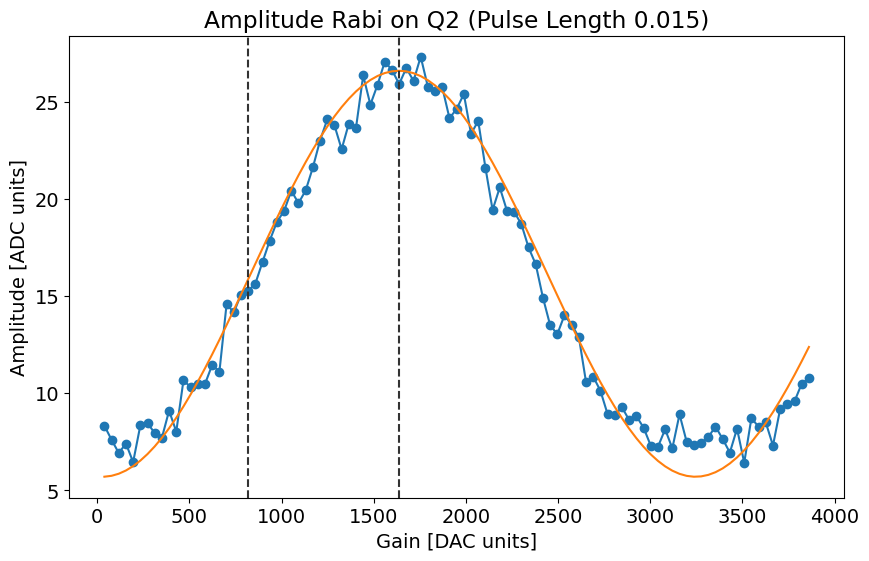

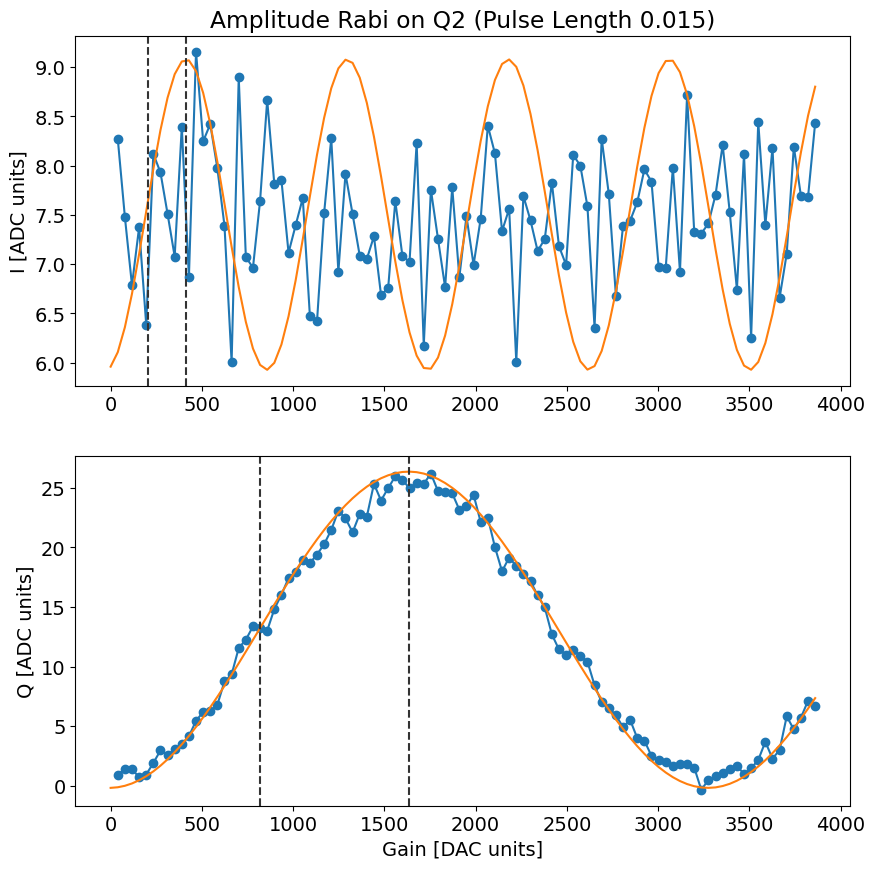

In [73]:
# # TESTING
# amprabiEF = meas.AmplitudeRabiEFExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramseyEF_qubit0.h5')
# data = amprabiEF.analyze(data=temp_data, fit=True)
# amprabiEF.display(data=data, fit=True)

amprabiEF.analyze(fit=True)
amprabiEF.display(fit=True)

In [346]:
amprabiEF.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00001_amp_rabi_EF_qubit0.h5


### Qubit temperature
Run amplitude rabi EF twice, once with and once without pulse_ge. Input the amplitude of the rabi oscillation (printed in the cell below) for each of these cases to calculate qubit temperature from the ratio.

In [242]:
# NATRUAL CONSTANTS
h = 6.62607015e-34
fge = 1e6*(amprabiEF.cfg.device.qubit.f_ge[qubit_i] + amprabiEF.cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i])
kB = 1.380649e-23
################

# print(amprabiEF.data.keys())
amps = amprabiEF.data['amps']
avgq = amprabiEF.data['avgq']

print(np.max(avgq) - np.min(avgq))
efamp_normal = 40
efamp_nopulse = abs(335-327)

print('Qubit temp [mK]:', 1e3*-h*fge/(kB*np.log(efamp_nopulse/efamp_normal)))


15.322239324928832
Qubit temp [mK]: 103.07902923184261


## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [155]:
1/(soc.cycles2us(1)*151)

2.3178576158940403

In [18]:
t2EFr = meas.RamseyEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(40), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=150,
    ramsey_freq=0.5, # [MHz]
    reps=200,
    rounds=10,
    qubit=qubit_i,
)

print(t2EFr.cfg)

t2EFr.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [45, 127, 55, 50], 'f_ge': [4128.575129385544, 3457.2422590133906, 4782.305489871236, 4396.915066710553], 'f_Q1_ZZ': [3452.0169427371175, 3457.338723559245, 3456.1893267454375, 3456.018803727748], 'f_Q_ZZ1': [4123.341754941294, 3457.338723559245, 0, 0], 'f_ef': [3902.5097729724093, 3356.7928599815136, 4592.511526938749, 4223.758894341571], 'f_EgGf': [2681.44696031, -1, 2022.3, 2407.9], 'f_EgGf_Q': [-1, -1, 5916.8, 5166.4], 'gs': [54.34474556, 56.18845266, 43.07411448, 5.80677427, 2.37708297, 6.56997134], 'ZZs': [0.0, -5.321780822127494, -0.15523394324009132, -0.5691491834904809, -5.321780822127494, 0.0, -1.1493968138074706, -1.319919831496918, -0.15523394324009132, -1.1493968138074706, 0.0, -1.2349280184125746, -0.6247231879115134, -1.319919831496918, -1.2349280184125746, 0.0], 'pulses': {'pi_ge': {'gain': [29539, 824, 2328, 2534], 'sigma': [0.015, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_ge_IQ': {'gain': 1373}, 'pi_ef': {'gain': [25302, 473, 1633, 1770],

  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 5.339919463087248, which is out of bounds 0.007264864864864865 to 1.0897297297297297. Instead init to 0.5484972972972972
Current EF frequency: 4592.511526938749
Fit frequency from I [MHz]: 0.5363907587263216
Suggested new EF frequencies from fit avgi [MHz]:
 	4592.475136180023
 	4591.475136180023
T2 Ramsey EF from fit avgi [us]: 4.1294642857142865
Fit frequency from Q [MHz]: 0.5458507988081153
Suggested new EF frequencies from fit avgq [MHz]:
 	4592.465676139941
 	4591.465676139941
T2 Ramsey EF from fit avgq [us]: 9.248111585394811


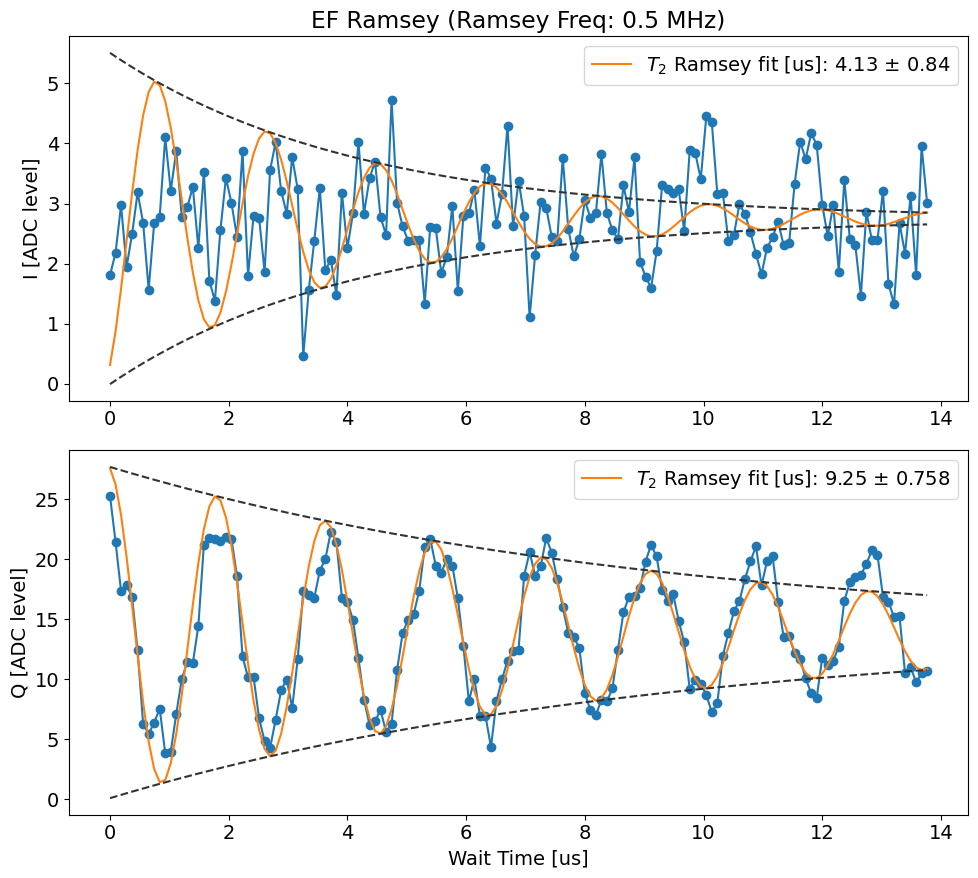

In [22]:
# # TESTING
# t2EFr = meas.RamseyEFExperiment(config_file=config_path)
# t2EFr.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data = prev_data(expt_path, '00000_ramseyEF_qubit0.h5')
# temp_data = temp_data[0]
# data = t2EFr.analyze(data=temp_data, fit=True)
# t2EFr.display(data=data, fit=True)

t2EFr.analyze(fit=True)
t2EFr.display(fit=True)

In [363]:
t2EFr.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00001_ramseyEF_qubit0.h5


# AC stark shift

Determine how much effective power is being applied for a drive detuned from qubit frequency

In [28]:
acspec = meas.ACStarkShiftPulseProbeExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ac_stark_shift_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 50
npts_f = 150

span_gain = 30000
npts_gain = 5

pump_params=dict(
    ch=4,
    type='full',
    nyquist=1,
)

acspec.cfg.expt = dict(
    start_f=acspec.cfg.device.qubit.f_ge[qubit_i]-span_f/2, # Pulse frequency [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,
    start_gain=1, # pump tone gain
    step_gain=int(span_gain/npts_gain),
    expts_gain=npts_gain,
    # pump_params=acspec.cfg.hw.soc.dacs.swap,
    pump_params=pump_params,
    # pump_freq=3300,
    pump_freq=acspec.cfg.device.qubit.f_EgGf[2],
    pump_length=12, # [us]
    qubit_gain=800,
    qubit_length=10, # [us]
    reps=1000,
    rounds=20, # Number averages per point
    qubit=qubit_i,
)
acspec.cfg.device.readout.relax_delay = 10
print(acspec.cfg)

acspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [70, 120, 40, 5], 'f_ge': [743.119, 3476.716, 166.5217, 449.757], 'f_ef': [649.12, 3376.34, -59.294, 295.9599], 'f_EgGf': [2105, -1, 2686.5343, 2403.299], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [27145, 13869, 13869, 10606], 'sigma': [0.035, 0.015, 0.02, 0.025], 'type': 'gauss'}, 'pi_ef': {'gain': [4713, 22501, 14543, 4728], 'sigma': [0.02, 0.025, 0.025, 0.025], 'type': 'gauss'}, 'pi_EgGf': {'gain': [1000, 0, 1000, 1000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 120, 'frequency': [810.409984606071, -805.058197780235, -82.367068, 79.3372763161615], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.085, 0.03, 0.025, 0.07], 'phase': [0, 0, 0, 0], 'threshold_ge': [0, 0, 0, 0], 'threshold_ef': [1, 1, 1, 1], 'readout_length': [5, 5, 5, 5], 'relax_delay': 10}}, 'hw': {'lo': {'readout': {'frequency': '5925e6', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4

  0%|          | 0/5 [00:00<?, ?it/s]

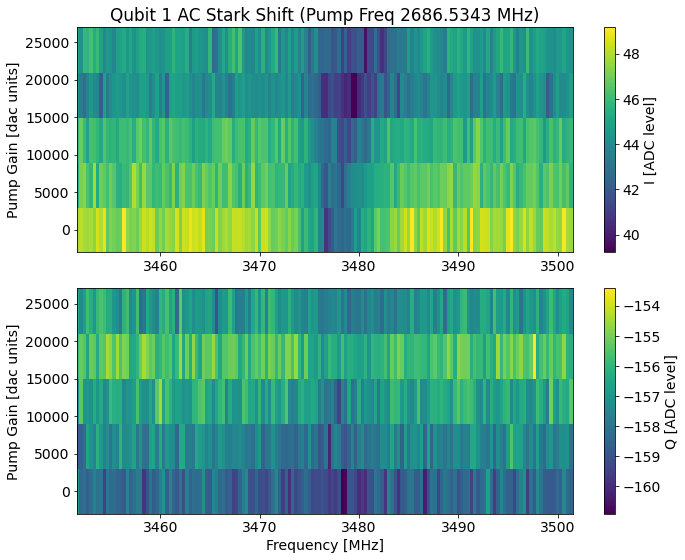

In [29]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = acspec.analyze(data=temp_data)

acspec.analyze()
acspec.display()

In [30]:
acspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00002_ac_stark_shift_qubit1.h5


# Single qubit RB

In [33]:
# qubit_i = 3
qubits = [3, 1]

{'device': {'qubit': {'T1': [45, 127, 55, 50], 'f_ge': [4128.575129385544, 3457.2422590133906, 4782.305489871236, 4396.915066710553], 'f_Q1_ZZ': [3452.0169427371175, 3457.338723559245, 3456.1893267454375, 3456.018803727748], 'f_Q_ZZ1': [4123.341754941294, 3457.338723559245, 0, 0], 'f_ef': [3902.5097729724093, 3356.7928599815136, 4592.465676139941, 4223.758894341571], 'f_EgGf': [2681.44696031, -1, 2028.5, 2407.9], 'f_EgGf_Q': [-1, -1, 5916.5, 5166.4], 'gs': [54.34474556, 56.18845266, 43.07411448, 5.80677427, 2.37708297, 6.56997134], 'ZZs': [0.0, -5.321780822127494, -0.15523394324009132, -0.5691491834904809, -5.321780822127494, 0.0, -1.1493968138074706, -1.319919831496918, -0.15523394324009132, -1.1493968138074706, 0.0, -1.2349280184125746, -0.6247231879115134, -1.319919831496918, -1.2349280184125746, 0.0], 'pulses': {'pi_ge': {'gain': [29539, 824, 2328, 2534], 'sigma': [0.015, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_ge_IQ': {'gain': 1373}, 'pi_ef': {'gain': [25302, 473, 1633, 1770],

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)


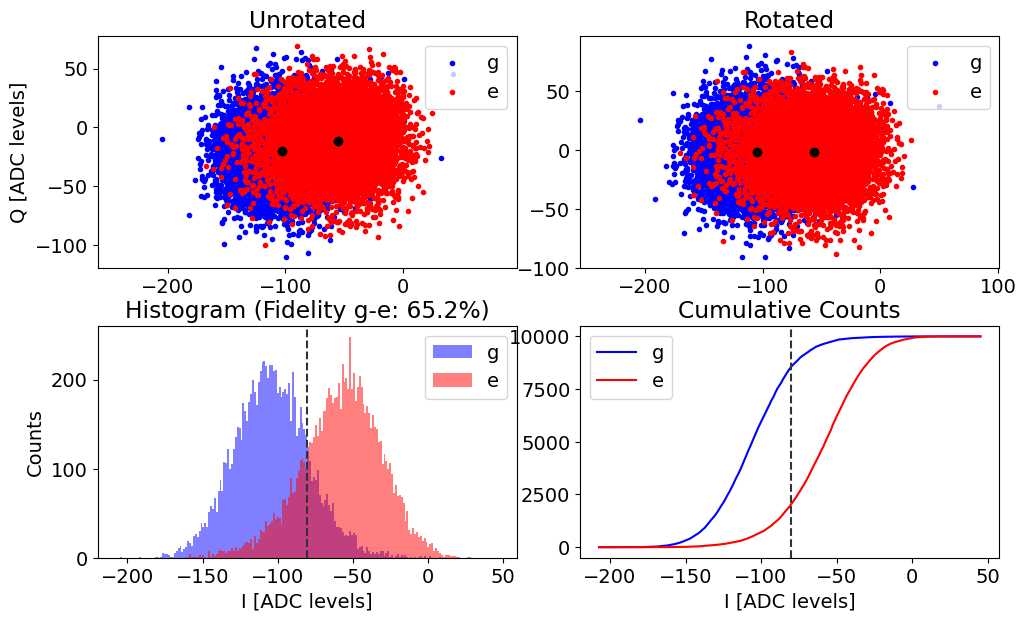

ge fidelity (%): 65.23326166308316 	 angle (deg): -10.09126907922383 	 threshold ge: -80.38343027701833
Qubit  (1)


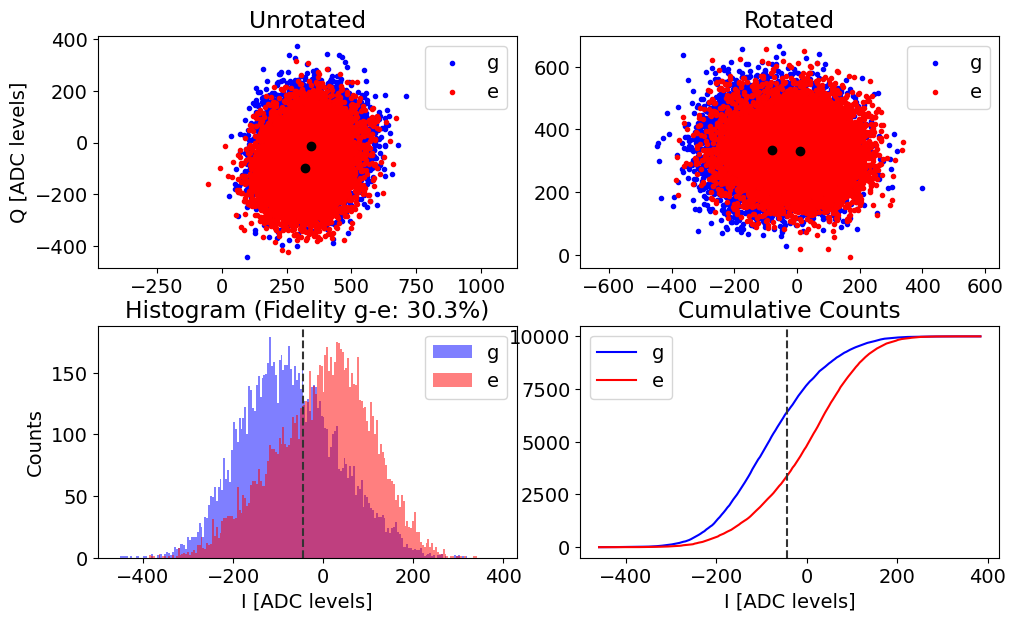

ge fidelity (%): 30.34151707585379 	 angle (deg): 105.61006859616839 	 threshold ge: -43.71112346297582


  0%|          | 0/10 [00:00<?, ?it/s]

In [34]:
rbprog = meas.SimultaneousRBExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb1Q_qubit{qubit_i}",
    config_file=config_path,
)

rbprog.cfg.expt = dict(
    start=1, # rb depth start
    step=8, # step rb depth
    expts=10, # number steps
    reps=1500, # number averages per unique sequence
    variations=30, # number different sequences per depth
    # gate_char='X', # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    use_EgGf_subspace=True, # specifies whether to run RB treating EgGf as the TLS subspace
    # qubits=[qubit_i], # the qubits to perform simultaneous RB on (if eg-gf, q should be qA != 1)
    qubits=qubits,
    qDrive=qubits[0],
    singleshot_reps=10000, # reps per state for singleshot calibration
    post_process='scale', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None
)

print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

[ 1  9 17 25 33 41 49 57 65 73] [0.98214666 0.82970777 0.76575148 0.71427463 0.68531801 0.74395723
 0.6833666  0.66898771 0.68983588 0.63463886]
[0.92660901 0.32893114 0.67318673]
0.00019449726073400068 0.0007750267189490789 0.00017122545382511754
[ 1  9 17 25 33 41 49 57 65 73] [0.76545113 0.5367573  0.44050192 0.3128885  0.26224466 0.31186479
 0.24846722 0.20877679 0.21028826 0.1356866 ]
Attempted to init fitparam 2 to -0.24606171690506073, which is out of bounds 0 to 0.8823617771111685. Instead init to 0.44118088855558424
[0.94917456 0.6086101  0.17658234]
7.43617488395627e-05 0.0015605080732767594 0.0007844064134391776
Running regular RB on EgGf subspace
Depolarizing parameter p from fit: 0.9266090062384614 +/- 0.013946227473191476
Average RB gate error: 0.0550432453211539 +/- 0.010459670604893606
	Fidelity=1-error: 0.9449567546788461 +/- 0.010459670604893606


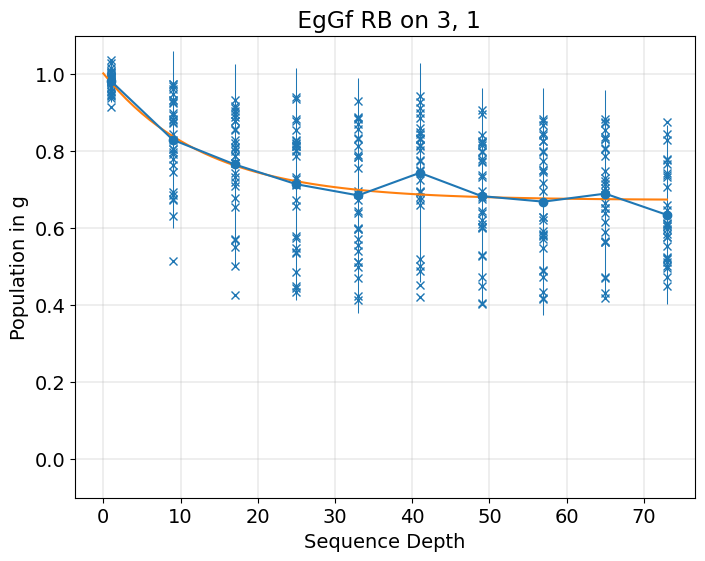

In [35]:
rbprog.analyze(fit=True)
rbprog.display(fit=True, qubit=qubits)

In [264]:
p_irb = 0.954568577245045  
p_rb = 0.9623 
print(meas.fitting.rb_error(p_rb, 2))
print(meas.fitting.rb_gate_fidelity(p_rb, p_irb, 2))

0.018850000000000033
0.995982841756752


In [411]:
rbprog.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_rb1Q_qubit0.h5


TypeError: Object dtype dtype('O') has no native HDF5 equivalent

# Repeat over time

In [45]:
import time

In [53]:
debug = False

start_time = time.time()

all_fids = []
all_T2R = []
all_T2R_err = []
times = []

if debug:
    max_time = 5*60
    print_time = 0
    wait_time = 0
else:
    max_time = 50*60*60
    print_time = 3*60*60
    wait_time = 10*60

time_of_last_print = time.time()
while time.time() - start_time < max_time:
    times.append(time.time()-start_time)

    shot = meas.HistogramExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"single_shot_qubit{qubit_i}",
        config_file=config_path,
    )

    shot.cfg.expt = dict(
        reps=20000,
        check_f=False,
        qubit=qubit_i,
    )
    shot.go(analyze=False, display=debug, progress=False, save=False)
    shot.analyze(verbose=False)
    all_fids.append(shot.data['fids'][0])


    t2r = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{qubit_i}",
        config_file=config_path,
    )

    t2r.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(20), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
        expts=150,
        ramsey_freq=0.5, # [MHz]
        reps=100,
        rounds=20,
        qubits=[qubit_i],
        checkZZ=False,
        checkEF=False,
    )
    t2r.go(analyze=True, display=debug, progress=False, save=False)
    t2r_fit, t2r_fit_err, t2r_adjust = meas.fitting.get_best_fit(t2r.data, get_best_data_params=['f_adjust_ramsey'])

    all_T2R.append(t2r_fit[3])
    all_T2R_err.append(np.sqrt(t2r_fit_err[3][3]))

    time.sleep(wait_time)

    if time.time() - time_of_last_print > print_time:
        print('all_fids =', all_fids)
        print('all_T2R =', all_T2R)
        print('all_T2R_err =', all_T2R_err)
        print('times =', times)
        time_of_last_print = time.time()


Attempted to init fitparam 1 to 2.3091543624161073, which is out of bounds 0.01452972972972973 to 2.1794594594594594. Instead init to 1.0969945945945945
Attempted to init fitparam 1 to 8.659328859060402, which is out of bounds 0.01452972972972973 to 2.1794594594594594. Instead init to 1.0969945945945945
Attempted to init fitparam 1 to 2.886442953020134, which is out of bounds 0.01452972972972973 to 2.1794594594594594. Instead init to 1.0969945945945945
Attempted to init fitparam 1 to 3.463731543624161, which is out of bounds 0.01452972972972973 to 2.1794594594594594. Instead init to 1.0969945945945945
Attempted to init fitparam 1 to 3.463731543624161, which is out of bounds 0.01452972972972973 to 2.1794594594594594. Instead init to 1.0969945945945945
Attempted to init fitparam 1 to 3.463731543624161, which is out of bounds 0.01452972972972973 to 2.1794594594594594. Instead init to 1.0969945945945945
Attempted to init fitparam 1 to 2.453476510067114, which is out of bounds 0.01452972972

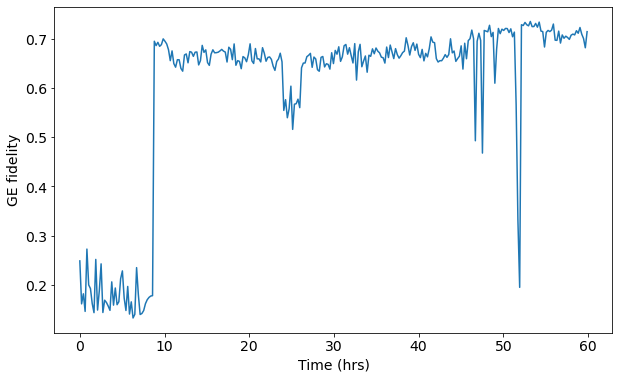

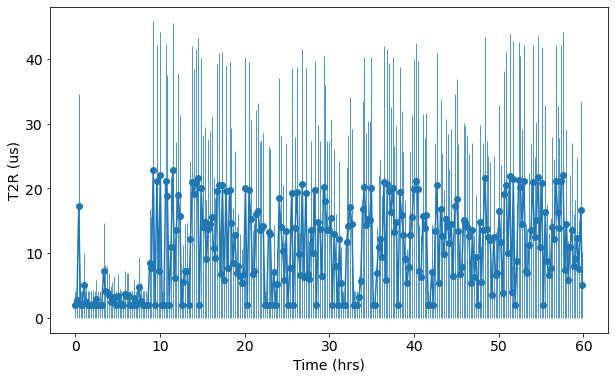

In [54]:
times = np.asarray(times)
plt.figure(figsize=(10, 6))
plt.plot(times/60/60, all_fids)
plt.xlabel('Time (hrs)')
plt.ylabel('GE fidelity')
plt.show()

plt.figure(figsize=(10, 6))
plt.errorbar(times/60/60, all_T2R, fmt='o-', yerr=all_T2R, color='tab:blue', elinewidth=0.75)
plt.xlabel('Time (hrs)')
plt.ylabel('T2R (us)')
plt.show()